# Main Clustering Script
Author: Ananda Kurth

---
## Part 1: Setup  
---
*This part of the script is to setup the data for the clustering algorithm.*

### 1.1: Import Libraries and Configure Plotting Style
*This initial step involves importing essential libraries and setting the plotting style.*

In [1]:
# Standard library imports
import gc
import joblib
import os

# Data manipulation and scientific computing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Scikit-learn imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# SciPy imports
from scipy.cluster import hierarchy
from scipy.stats import norm, pearsonr

# Folium for map visualizations
import folium
from branca.element import MacroElement
from jinja2 import Template

# Custom module imports
from API_and_Data.survey_data import SurveyData
from API_and_Data.weather_API import get_weather_data
from API_and_Data.boum_API import get_boum_data
from msc.MathClass import interpolate_dataframe_to_resolution

# ---------------------------------------------------------
# Set Plotting Style
# ---------------------------------------------------------

# Setting the aesthetic style of the plots
sns.set(style='whitegrid', context='notebook', palette='colorblind', font_scale=1.2)
color_palette = sns.color_palette("colorblind", 25)

### 1.2: Instantiate Data Retrieval and Processing Classes
*Here, the instance of the survey Data class is created.*


In [2]:
survey_data_instance = SurveyData()  # Instance of SurveyData class for handling survey data

### 1.3: Configure Data File Paths and Names
*Setting up the file paths and names for data files.*

In [3]:
# Data File Paths
# Grouping all data file path assignments for easy reference and modification
boum_device_list_file = "../data/boum_device_list_all.txt"  # Path to Boum device list file
swiss_temperature_file = "../data/climate-reports-normtables_tre200m0_1991-2020_de.txt"  # Path to Swiss temperature data file
swiss_dni_file = "../data/climate-reports-normtables_gre000m0_1981-2000_de.txt"  # Path to Swiss DNI data file
survey_data_file = "../data/survey_data.csv"  # Path to survey data file

---
### Optional Steps: Data Loading
#### Loading Boum Data
*This section is optional as pickled versions of the resulting datasets will be available later. It covers the steps for loading the Boum data if required.*


In [4]:
# The following code is commented out. Uncomment to load and process Boum data if needed.
# boum_data = get_boum_data(boum_device_list_file)
# boum_data.to_pickle('../data/boum_data', compression='infer', protocol=5)

#### Data Processing
*This section is optional as pickled versions of data will be available. It outlines steps for processing data if required.*


#### Swiss Temperature and DNI Data Analysis
*This section focuses on processing and analyzing Swiss data:*
- *Data reading using pandas.*
- *Timestamp conversion and month-based grouping.*
- *Calculation of mean temperatures and DNI and visualization with seaborn.*

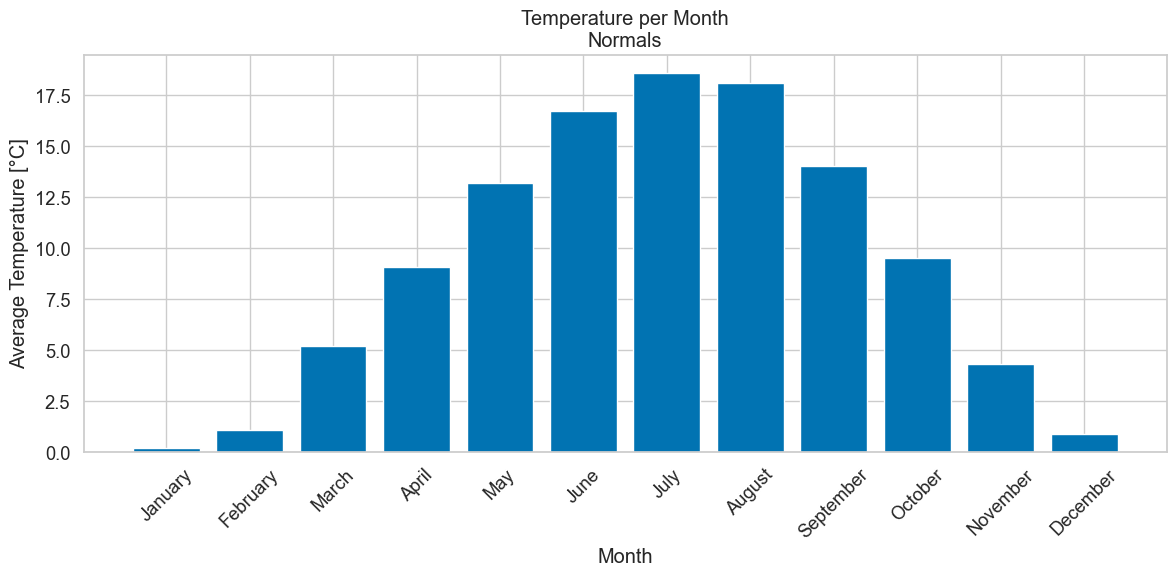

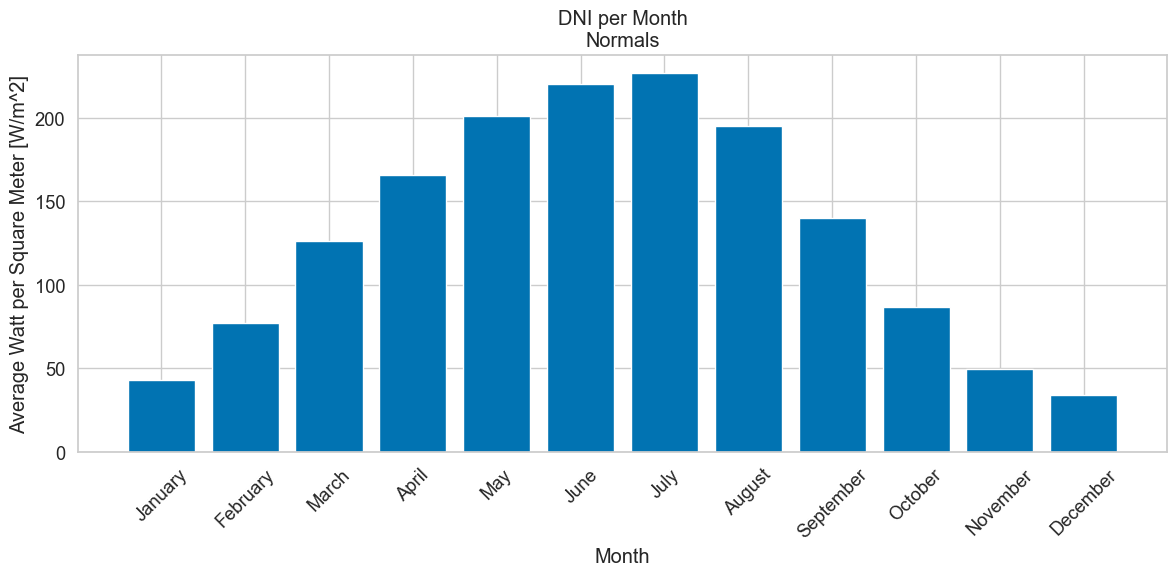

In [5]:
def plot_mean_dni(monthly_data, title, file_name):
    """
    Plot the average DNI by month.

    Parameters:
        monthly_data (pd.Series): Series containing the DNI data.
        title (str): Title of the plot.
        file_name (str): Name of the file to save the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.bar(monthly_data.index, monthly_data, color=color_palette[0])
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel("Average Watt per Square Meter [W/m^2]")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"../plots/{file_name}")
    plt.show()


def plot_mean_temperature(monthly_data, title, file_name):
    """
    Plot the average DNI by month.

    Parameters:
        monthly_data (pd.Series): Series containing the DNI data.
        title (str): Title of the plot.
        file_name (str): Name of the file to save the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.bar(monthly_data.index, monthly_data, color=color_palette[0])
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel("Average Temperature [°C]")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"../plots/{file_name}")
    plt.show()


def process_swiss_mean_data(data_file, data_type):
    """
    Process the Swiss mean data (temperature or DNI) from the specified file.

    Parameters:
        data_file (str): The file path for the data.
        data_type (str): Type of the data ('Temperature' or 'DNI').

    Returns:
        pd.Series: A series of median values (temperature or DNI).
    """
    try:
        southern_stations = ['Cimetta', 'Locarno', 'Lugano', 'Magadino', 'Poschiavo', 'Stabio']
        full_month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
                            'October', 'November', 'December']

        df = pd.read_csv(data_file, sep="\t")  # Assuming tab-separated file

        # Filter based on stations and altitude
        to_drop = df[(~df['Station'].isin(southern_stations)) & (df['Stationshoehe'] >= 1600)].index
        df.drop(to_drop, inplace=True)

        # Drop unnecessary columns
        df.drop(columns=['Station', 'Stationshoehe', 'CH Koordinaten', 'Referenzperiode', 'Jahr'], inplace=True)

        df.columns = full_month_names  # Renaming columns to full month names

        monthly_median = df.median()  # Calculating medians           
        data_type_str = 'temp' if data_type == 'Temperature' else 'dni'
        monthly_median.to_pickle(f"../data/{data_type_str}_value_CH", compression="infer", protocol=5)

        plot_type = plot_mean_temperature if data_type == 'Temperature' else plot_mean_dni
        title = f"{data_type} per Month\nNormals"
        file_name = f"climate_reports_by_month_{data_type_str}.png"
        plot_type(monthly_median, title, file_name)

        return monthly_median
    except FileNotFoundError:
        print(f"File not found: {data_file}")
    except Exception as e:
        print(f"An error occurred: {e}")


# Usage for temperature data
temp_value_CH = process_swiss_mean_data(swiss_temperature_file, 'Temperature')

# Usage for DNI data
dni_value_CH = process_swiss_mean_data(swiss_dni_file, 'DNI')


---
### 1.4 Loading Pickled Data Sets
*This part covers the loading of previously pickled data sets, which are essential for subsequent data processing and analysis steps.*


In [6]:
try:
    # Loading various datasets required for the analysis
    # BOUM data containing various sensor measurements
    boum_data = pd.read_pickle("../data/boum_data_new")

    # Survey data with survey information for survey data analysis
    survey_data = pd.read_csv("../data/survey_data.csv")

    # Weather data corresponding to the BOUM device data for each location
    weather_data = pd.read_pickle("../data/weather_data_call")

    # Swiss mean Direct Normal Irradiance (DNI) values
    dni_value_CH = pd.read_pickle("../data/dni_value_CH")

    # Swiss mean temperature values
    temp_value_CH = pd.read_pickle("../data/temp_value_CH")

    # Historical weather data for each month 
    historical_weather_data = pd.read_pickle("../data/hist_weather_pickled")

except FileNotFoundError as e:
    print(f"Error loading file: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

---
## Part 2: Data Cleaning and Preprocessing
---
*In this section, data cleaning and preprocessing steps are outlined, including the extraction of coordinates from survey data files and preprocessing of timestamps in data files to ensure consistency and accuracy.*

### 2.1: Extracting Coordinates from Survey Data
*The procedure detailed here extracts coordinates of each BOUM device from the survey data file, involving reading device lists, filtering survey data, and creating a coordinate dictionary.*


In [7]:
def get_coordinates(device_list_file, survey_data_file):
    """
    Extracts coordinates from survey data for devices listed in the device list file.

    Parameters:
        device_list_file (str): Filename containing the list of device IDs.
        survey_data_file (str): Filename of the survey data CSV file.
    Returns:
        dict: Dictionary mapping device IDs to their corresponding latitude and longitude.
    """
    if not os.path.exists(f"../data/{device_list_file}"):
        print(f"Device list file not found: {device_list_file}")
        return {}

    try:
        survey_data = pd.read_csv(survey_data_file)
        survey_data = survey_data.dropna(subset=["latitude", "longitude"])

        with open(f"../data/{device_list_file}", "r") as file:
            device_list = {line.strip() for line in file}  # Using a set for efficient lookup

        # Filtering the survey data for device IDs present in the device list
        filtered_data = survey_data[survey_data["deviceId_boum"].isin(device_list)]

        # Creating a dictionary of coordinates
        coordinates_dict = {row["deviceId_boum"]: (row["latitude"], row["longitude"]) for index, row in
                            filtered_data.iterrows()}

        return coordinates_dict

    except FileNotFoundError:
        print(f"Survey data file not found: {survey_data_file}")
    except Exception as e:
        print(f"An error occurred: {e}")
        return {}


coordinates_dict = get_coordinates(boum_device_list_file, survey_data_file)

### 2.2: Preprocessing Timestamps in Data Files
*This process involves converting 'timestamp' columns to datetime objects, normalizing timestamps, and interpolating data to a regular interval. The timestamp column is then set as the DataFrame index.*


In [8]:
def preprocess_timestamps(data_frame):
    """
    Preprocesses the timestamps in the given DataFrame.

    Converts the timestamp to a datetime object, normalizes it,
    interpolates the data to a specified resolution, and sets the timestamp as the index.

    Parameters:
        data_frame (pd.DataFrame): DataFrame containing a 'timestamp' column.

    Returns:
        pd.DataFrame: The DataFrame with preprocessed timestamps.
    """
    try:
        # Converting 'timestamp' to datetime and removing timezone info
        data_frame["timestamp"] = pd.to_datetime(data_frame["timestamp"]).dt.tz_localize(None)

        # Converting timestamp to seconds (from milliseconds)
        data_frame["timestamp"] = data_frame["timestamp"].values.astype(np.int64) // 10 ** 6 // 1000

        # Interpolating data to a regular interval (600 seconds)
        data_frame = interpolate_dataframe_to_resolution(data_frame, "timestamp", 600, data_frame.columns, "values")

        # Converting back to datetime and setting as index
        data_frame["timestamp"] = pd.to_datetime(data_frame["timestamp"], unit="s")
        data_frame.set_index("timestamp", inplace=True)

        return data_frame

    except Exception as e:
        print(f"An error occurred in preprocess_timestamps: {e}")
        return data_frame  # Returning the original DataFrame in case of an error


# Applying the preprocessing function to the datasets
boum_data = preprocess_timestamps(boum_data)
weather_data = preprocess_timestamps(weather_data)

*Dropping columns that contain 'time' in their names from weather_data*

In [9]:
# This is done to remove any redundant or unnecessary time-related information
time_columns = weather_data.filter(like='time').columns
if len(time_columns) > 0:
    weather_data.drop(columns=time_columns, inplace=True)
else:
    print("No columns to drop that contain 'time'")

### 2.3: Extracting Monthly Mean Temperatures and Radiation
*This section includes the extraction and summarization of monthly mean temperatures and radiation from historical weather data, including calculating mean values, grouping by month, and generating descriptive statistics.*


In [10]:
def extract_historical_monthly_mean(data):
    """
    Extracts and summarizes monthly mean temperatures and radiation from historical weather data.

    Parameters:
        data (pd.DataFrame): DataFrame containing historical weather data with a 'timestamp' index.

    Returns:
        tuple: Two DataFrames containing monthly descriptive statistics for temperature and radiation.
    """
    try:
        if not pd.api.types.is_datetime64_any_dtype(data.index):
            data.set_index("timestamp", inplace=True)

        # Identifying temperature and radiation columns
        temperature_columns = [col for col in data if "temperature_2m" in col]
        radiation_columns = [col for col in data if "direct_normal" in col]

        # Calculating monthly means and descriptive statistics
        monthly_temperature = data[temperature_columns].mean(axis=1).groupby(data.index.month).describe()
        monthly_radiation = data[radiation_columns].mean(axis=1).groupby(data.index.month).describe()

        return monthly_temperature, monthly_radiation

    except Exception as e:
        print(f"An error occurred in extract_historical_monthly_mean: {e}")
        return None, None


# Applying the function to the historical weather data
monthly_temperature, monthly_radiation = extract_historical_monthly_mean(historical_weather_data)


### 2.4: Calculating Percentiles for Temperature and Radiation Data
*Thresholds for temperature and radiation data are calculated based on percentiles. This involves defining default percentiles, validating input data, and calculating thresholds for each month using statistical methods.*


In [11]:
def calculate_thresholds(data, month_data, mode, percentiles=None):
    """
    Calculates thresholds for the DNI and temperature data based on percentiles.

    Parameters:
        data (pd.Series): Series containing mean values for each month, indexed by month number (0-11).
        month_data (pd.DataFrame): DataFrame containing monthly statistics, indexed by month number (1-12).
        mode (str): The type of data ('Temperature' for temperature, 'Radiation' for radiation).
        percentiles (list): List of percentiles to calculate thresholds.

    Returns:
        list: A list of lists containing calculated thresholds for each month.
    """

    month_data.reset_index(inplace=True)  # Resetting the index of the monthly data to 0-11

    if percentiles is None:
        percentiles = [20, 50, 80]

    if not (0 <= min(percentiles) <= 100 and 0 <= max(percentiles) <= 100):  # Checking if the percentiles are valid
        raise ValueError("Percentiles must be between 0 and 100")

    if len(data) != 12 or len(month_data) != 12:  # Checking if the data and month_data have the same number of months
        raise ValueError("Data and month_data should each contain 12 months")

    thresholds = []
    for month_num in range(0, 12):  # Calculating thresholds for each month
        mean = data[month_num]  # Getting the mean value for the month
        std = month_data.loc[month_num, "std"]  # Getting the standard deviation for the month
        month_thresholds = [max(0, int(norm.ppf(p / 100, loc=mean, scale=std))) if mode == 'Radiation' else int(
            norm.ppf(p / 100, loc=mean, scale=std)) for p in percentiles]  # Calculating thresholds for each percentile
        thresholds.append(month_thresholds)  # Adding the calculated thresholds to the list

    return thresholds


# Applying the function to calculate thresholds
temperature_thresholds = calculate_thresholds(temp_value_CH, monthly_temperature, 'Temperature')
radiation_thresholds = calculate_thresholds(dni_value_CH, monthly_radiation, 'Radiation')

### 2.5: Correcting Temperature and Voltage Readings in Data
*The focus here is on correcting temperature and voltage readings in a DataFrame. Steps include creating a DataFrame copy, filtering and correcting temperature and voltage data, resampling to an hourly frequency, and plotting for comparison.*


In [12]:
def correct_data(data_frame, temp_correction_factor=0.775, temp_offset=2.748, voltage_threshold=5.0):
    """
    Corrects the temperature and voltage readings in the dataframe.

    Parameters:
        data_frame (pd.DataFrame): DataFrame containing the data to be corrected.
        temp_correction_factor (float): Multiplicative factor for temperature correction.
        temp_offset (float): Offset value to be added to temperature after applying a correction factor.
        voltage_threshold (float): Threshold value for filtering voltage readings.

    Returns:
        pd.DataFrame: Corrected DataFrame.
    """
    # Creating a copy of the DataFrame to avoid modifying the original data
    df = data_frame.copy()

    # Setting 'timestamp' as index if it exists
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df.set_index("timestamp", inplace=True)

    # Identifying temperature and voltage columns
    temperature_columns = [col for col in df.columns if col.startswith("temperature_boum")]
    voltage_columns = [col.replace("temperature", "solarVoltage") for col in temperature_columns]

    # Converting temperature and voltage columns to numeric, coerce errors
    df = df[temperature_columns + voltage_columns].apply(pd.to_numeric, errors="coerce")

    # Creating a copy of the DataFrame for comparison later
    df_original = df.copy()

    # Filtering out voltage values above the threshold
    df[voltage_columns] = df[voltage_columns][df[voltage_columns] <= voltage_threshold]

    # Applying the temperature correction factor and offset
    df[temperature_columns] = temp_correction_factor * df[temperature_columns] + temp_offset

    # Removing consecutive duplicate readings (assuming data cleaning step)
    df[temperature_columns + voltage_columns] = df[temperature_columns + voltage_columns].mask(
        df[temperature_columns + voltage_columns].diff().round(2) == 0)

    # Resampling data hourly and dropping rows with all NaN values
    df_corrected = df.resample("30T").mean().dropna(how="all")

    # Plotting temperature comparison before and after correction if wanted
    # plot_temperature_comparison(df_corrected, df_original, temperature_columns)

    return df_corrected


def plot_temperature_comparison(df_corrected, df_original, temperature_columns):
    """
    Plots a comparison of original and corrected temperature readings.

    Parameters:
        df_corrected (pd.DataFrame): DataFrame with corrected data.
        df_original (pd.DataFrame): DataFrame with original data.
        temperature_columns (list): List of column names for temperature data.
    """
    # Setting up the plot
    plt.figure(figsize=(12, 6))

    # Plotting each temperature column from original and corrected data
    for col in temperature_columns:
        plt.plot(df_original.index, df_original[col], color=color_palette[0], alpha=0.5, label='Original')
        plt.plot(df_corrected.index, df_corrected[col], color=color_palette[1], alpha=1, label='Corrected')

    # Setting the x-axis limits
    plt.xlim(pd.Timestamp('2023-06-01'), df_original.index.max())

    # Adding plot title and axis labels
    plt.title('Temperature Readings: Original vs Corrected')
    plt.xlabel('Date')
    plt.ylabel('Temperature [°C]')

    # Creating and adding a legend to the plot
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    # Adding grid, adjusting layout, and saving the plot as a PNG file
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('../plots/Temperature_Comparison_Plot.png')

    # Displaying the plot
    plt.show()


# Applying the correction function to boum_data
boum_data = correct_data(boum_data)

Identifying temperature columns in the boum_data DataFrame

In [13]:
# This includes all columns that contain the string 'temperature_boum'
temperature_columns = boum_data.filter(like='temperature_boum').columns.tolist()

# Creating a list of corresponding voltage columns,
# this is done by replacing 'temperature' with 'solarVoltage' in each temperature column name
voltage_columns = [col.replace("temperature", "solarVoltage") for col in temperature_columns]

### 2.6: Identifying Time Range with Highest Mean Differences in Temperature and Voltage
*This section focuses on identifying the time range with the highest combined mean differences in temperature and voltage between locations. It involves calculating mean hourly differences, normalizing these values, and pinpointing the time range with the top 15% differences.*


Time range with the highest combined mean differences (top 15.0%): 11 to 14 hours


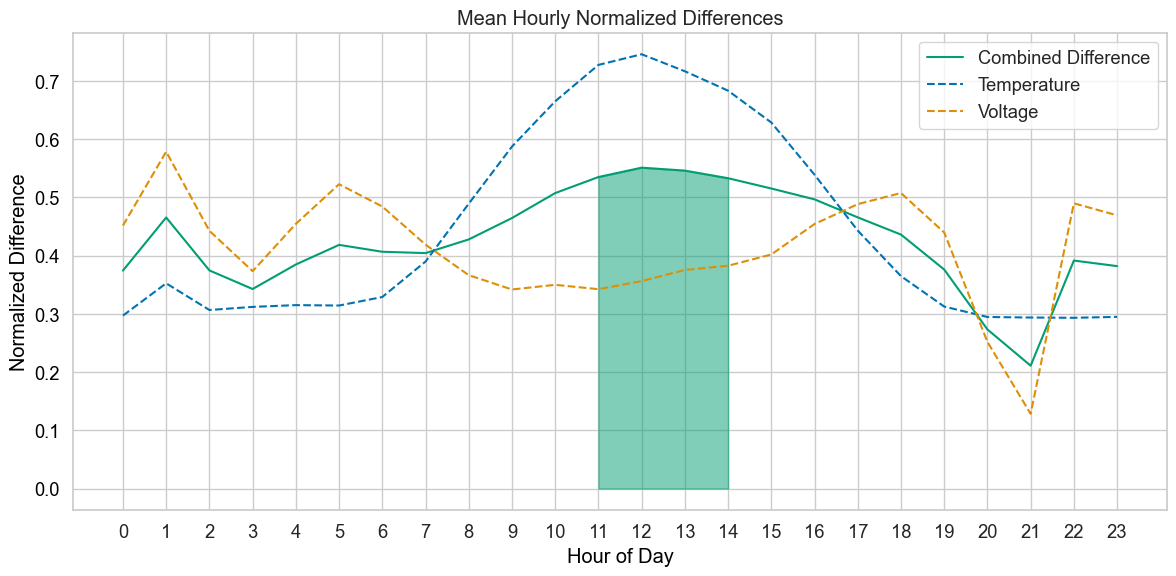

In [14]:
def find_peak_time():
    """
    Identifies the time range with the highest combined mean differences in temperature and voltage.

    This function calculates the mean hourly differences for both temperature and voltage, 
    normalizes these differences, and then finds the time range where these combined differences are in the top 10%.

    Returns:
        tuple: A tuple containing the minimum and maximum hours of the identified peak time range.
    """

    # Calculating the absolute difference between consecutive hourly readings for temperature and voltage
    hourly_temp_diff = boum_data[temperature_columns].diff(axis=1).abs()
    hourly_volt_diff = boum_data[voltage_columns].diff(axis=1).abs()

    # Grouping by hour and computing the mean difference for each hour
    mean_hourly_temp_diff = hourly_temp_diff.groupby(hourly_temp_diff.index.hour).mean()
    mean_hourly_volt_diff = hourly_volt_diff.groupby(hourly_volt_diff.index.hour).mean()

    # Normalizing the differences by their respective max values and averaging across columns
    mean_temp_diff = (mean_hourly_temp_diff / mean_hourly_temp_diff.max()).mean(axis=1)
    mean_volt_diff = (mean_hourly_volt_diff / mean_hourly_volt_diff.max()).mean(axis=1)

    # Combining the normalized temperature and voltage differences
    common_line = (mean_temp_diff + mean_volt_diff) / 2

    # Identifying the top percentage of hours with the highest mean differences
    top_percentage = 0.15
    threshold_value = common_line.quantile(1 - top_percentage)
    top_percent_index = common_line[common_line >= threshold_value].index

    # Determining the range of hours in the top percentage
    min_time = min(top_percent_index)
    max_time = max(top_percent_index)
    print(
        f"Time range with the highest combined mean differences (top {top_percentage * 100}%): {min_time} to {max_time} hours")

    # Plotting the peak hours
    plot_peak_hours(common_line, mean_temp_diff, mean_volt_diff, top_percent_index)

    return min_time, max_time


def plot_peak_hours(common_line, mean_temp_diff, mean_volt_diff, top_percent_index):
    """
    Plots the hourly normalized differences in temperature and voltage, highlighting the peak hours.

    Parameters:
        common_line (pd.Series): A series containing the combined normalized differences of temperature and voltage.
        mean_temp_diff (pd.Series): A series containing the mean hourly normalized temperature differences.
        mean_volt_diff (pd.Series): A series containing the mean hourly normalized voltage differences.
        top_percent_index (pd.Index): An index of hours that are in the top percentage of combined differences.

    This function creates a plot to visually compare the original and corrected temperature readings.
    """
    # Setting up the plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Defining colors for the plot
    color_temp = color_palette[0]
    color_volt = color_palette[1]
    color_combined = color_palette[2]

    # Plotting the normalized differences
    ax1.set_xlabel("Hour of Day", color='black')
    ax1.set_ylabel("Normalized Difference", color='black')
    ax1.plot(common_line.index, common_line, color=color_combined, label="Combined Difference")
    ax1.fill_between(top_percent_index, 0, common_line.loc[top_percent_index], color=color_combined, alpha=0.5)
    ax1.plot(mean_temp_diff.index, mean_temp_diff, color=color_temp, linestyle="--", label="Temperature")
    ax1.plot(mean_volt_diff.index, mean_volt_diff, color=color_volt, linestyle="--", label="Voltage")
    ax1.tick_params(axis="y", labelcolor='black')

    # Adding a title and customizing ticks
    ax1.set_title("Mean Hourly Normalized Differences")
    ax1.set_xticks(range(0, 24))
    ax1.legend(loc="upper right")

    # Finalizing and displaying the plot
    plt.tight_layout()
    plt.savefig("../plots/Hourly_Normalized_Differences.png")
    plt.show()


# Using the function to find the peak time based on temperature and voltage data
min_time, max_time = find_peak_time()

*Adding a new column to the boum_data DataFrame and the weather_data DataFrame, to more easily select specific months.*

In [15]:
# Adding a new column 'm' to boum_data representing the month number as an integer
boum_data["m"] = boum_data.index.month.astype(int)

# Adding another column 'month' to boum_data with the month and day formatted as "mm-dd"
boum_data["month"] = boum_data.index.strftime("%m-%d")

# Resetting the index of boum_data to convert 'timestamp' from the index to a regular column
boum_data.reset_index(inplace=True)

# For weather_data, adding a new column 'month' representing the month number as an integer
weather_data.loc[:, "month"] = weather_data.index.month.astype(int)

---
## Part 3: Data Processing and Preparation for Clustering
---
*This part of the notebook details the steps involved in processing and preparing data for clustering analysis, including preprocessing, merging temperature and radiation data, and refining the preprocessed data for easier analysis.*


### 3.1: Preprocessing Data for Clustering
*This function, `preprocess_data_for_clustering`, prepares data for clustering by processing temperature, solar voltage, and radiation data for specified months. It involves creating pivot tables for both Boum and weather data, and appending these tables to a compiled DataFrame.*


In [16]:
def get_column_names(boum_id):
    """
    Generates column names for temperature and solar voltage data based on a given BOUM ID.

    Parameters:
        boum_id (str): The identifier for a specific BOUM device.

    Returns:
        tuple: A tuple containing the formatted column names for temperature and solar voltage data.
    """
    return (
        f"temperature_2m_{boum_id}",
        f"temperature_boum_{boum_id}_boum_{boum_id}",
        f"solarVoltage_boum_{boum_id}_boum_{boum_id}",
        f"direct_normal_irradiance_{boum_id}"
    )


def sample_daily_mean(target_month, radiation_column, temperature_column, weather_data):
    """
    Samples daily mean values for specified temperature and radiation columns in a given month.

    Parameters:
        target_month (int): The month number to filter the data.
        radiation_column (str): The name of the radiation column.
        temperature_column (str): The name of the temperature column.
        weather_data (pd.DataFrame): The DataFrame containing weather data.

    Returns:
        tuple: Two DataFrames containing daily max values for radiation and temperature.
    """
    seasonal_data = weather_data[weather_data["month"] == target_month].copy()
    seasonal_data.drop(columns=[col for col in seasonal_data.columns if "time" in col], inplace=True)

    temperature_data = seasonal_data[temperature_column].resample("D").mean()
    radiation_data = seasonal_data[radiation_column].resample("D").mean()
    temperature_categories = np.digitize(temperature_data, temperature_thresholds[target_month - 1], right=True)
    radiation_categories = np.digitize(radiation_data, radiation_thresholds[target_month - 1], right=True)
    temperature_data = pd.DataFrame(temperature_data)
    radiation_data = pd.DataFrame(radiation_data)
    temperature_data["temperature_category"] = temperature_categories
    radiation_data["radiation_category"] = radiation_categories
    temperature_data["month"] = temperature_data.index.month
    radiation_data["month"] = radiation_data.index.month
    return radiation_data, temperature_data


def extract_data(boum_data, value_columns, data_value, target_month):
    """
    Extracts and processes data for a specific month, filtering it based on certain time constraints.

    Parameters:
        boum_data (pd.DataFrame): The DataFrame containing BOUM data.
        value_columns (str): The name of the column to be extracted.
        data_value (pd.DataFrame): DataFrame containing additional data to merge.
        target_month (int): The target month for data extraction.

    Returns:
        pd.DataFrame: A DataFrame with extracted and merged data.
    """
    extracted_data = boum_data[[value_columns, "timestamp"]].copy()
    try:
        extracted_data["hour"] = pd.to_datetime(extracted_data["timestamp"]).dt.hour
        extracted_data["month"] = pd.to_datetime(extracted_data["timestamp"]).dt.month
        extracted_data = extracted_data[extracted_data["month"] == target_month]
        extracted_data = extracted_data[extracted_data["hour"].between(min_time, max_time)].set_index(
            "timestamp").resample("D").median()
        extracted_data = pd.merge_ordered(extracted_data, data_value, on=["timestamp", "month"], how="outer")
    except Exception as e:
        print(f"Error in extract_data: {e}")
        return pd.DataFrame()
    return extracted_data


def create_pivot_table(data, category_column, value_column):
    """
    Helper function to create pivot tables.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data.
    category_column (str): Column name to group by.
    value_column (str): Column name for calculating mean.

    Returns:
    pd.DataFrame: Pivot table based on the specified category and value columns.
    """
    return data.groupby(category_column)[value_column].mean().reset_index().pivot_table(
        index=category_column, values=value_column, aggfunc="mean")


def append_to_final(final_data, solar_pivot, temperature_pivot, radiation_pivot, temp_pivot):
    """
    Appends given pivot tables to the final DataFrame.

    Parameters:
        final_data (pd.DataFrame): The DataFrame to append to.
        solar_pivot (pd.DataFrame): Pivot table for solar data.
        temperature_pivot (pd.DataFrame): Pivot table for temperature data.
        radiation_pivot (pd.DataFrame): Pivot table for radiation data.
        temp_pivot (pd.DataFrame): Additional pivot table for temperature data.

    Returns:
        pd.DataFrame: The updated final DataFrame with appended data.
    """
    if final_data.empty:
        # If final_data is empty, initialize it with the joined pivot tables
        final_data = temp_pivot.join(radiation_pivot).join(temperature_pivot).join(solar_pivot)
    else:
        # If final_data already contains data, append the new pivot tables
        final_data = final_data.join(temp_pivot).join(radiation_pivot).join(temperature_pivot).join(solar_pivot)

    return final_data


def preprocess_data_for_clustering(boum_data, weather_data, coordinates_dict, month):
    """
    Preprocesses data for clustering by extracting, processing, and merging temperature and radiation data.

    Parameters:
        boum_data (pd.DataFrame): DataFrame containing BOUM data.
        weather_data (pd.DataFrame): DataFrame containing weather data.
        coordinates_dict (dict): Dictionary mapping BOUM IDs to their coordinates.
        month (int): Month number to filter and process the data.

    Returns:
        pd.DataFrame: A DataFrame ready for clustering analysis.
    """
    avg_temp_and_radiation_by_category_and_month = pd.DataFrame() 
    for boum_id, coordinates in coordinates_dict.items():
        boum_id = boum_id[:8]
        try:
            temperature_column, boum_temperature_column, boum_solar_column, radiation_column = get_column_names(boum_id)
            weather_radiation_data, weather_temperature_data = sample_daily_mean(month, radiation_column,
                                                                                 temperature_column,
                                                                                 weather_data)
            boum_temperature_data = extract_data(boum_data, boum_temperature_column, weather_temperature_data, month)
            boum_solar_data = extract_data(boum_data, boum_solar_column, weather_radiation_data, month)

            pivot_boum_solar = create_pivot_table(boum_solar_data, ['radiation_category'], boum_solar_column)
            pivot_boum_temperature = create_pivot_table(boum_temperature_data, ["temperature_category"],
                                                        boum_temperature_column)
            pivot_radiation = create_pivot_table(weather_radiation_data, ["radiation_category", "month"],
                                                 radiation_column)
            pivot_temperature = create_pivot_table(weather_temperature_data, ["temperature_category", "month"],
                                                   temperature_column)
            avg_temp_and_radiation_by_category_and_month = append_to_final(avg_temp_and_radiation_by_category_and_month,
                                                                           pivot_boum_solar,
                                                                           pivot_boum_temperature, pivot_radiation,
                                                                           pivot_temperature)
            gc.collect()
        except KeyError as e:
            continue
        except Exception as e:
            print(f"An unexpected error occurred for BOUM ID {boum_id}: {e}")
            continue
    return avg_temp_and_radiation_by_category_and_month

#### 3.1.1: Data Preprocessing Pipeline for Specific Months
*For each month, the `preprocess_data_for_clustering` function is executed, processing data and returning a DataFrame. These DataFrames are then concatenated, forming the dataset for further analysis.*


In [17]:
# Concatenating the preprocessed data for each month from April to October into a single DataFrame.
resulting_data = pd.concat(
    [preprocess_data_for_clustering(boum_data, weather_data, coordinates_dict, month) for month in range(4, 11)]
)

# Displaying the resulting concatenated DataFrame
resulting_data.head(5)

temperature_2m_045259fa   
month radiation_category temperature_category                            
4     1                  0                                    2.390972  \
                         1                                    6.808661   
                         2                                   10.820462   
                         3                                   14.149306   
      2                  0                                    2.390972   

                                               direct_normal_irradiance_045259fa   
month radiation_category temperature_category                                      
4     1                  0                                             74.990833  \
                         1                                             74.990833   
                         2                                             74.990833   
                         3                                             74.990833   
      2                  0                                            284.600744   

                                               temperature_2m_5954b56b   
month radiation_category temperature_category                            
4     1                  0                                    1.242072  \
                         1                                    6.586307   
                         2                                   10.554083   
                         3                                   13.880556   
      2                  0                                    1.242072   

                                               direct_normal_irradiance_5954b56b   
month radiation_category temperature_category                                      
4     1                  0                                             70.894231  \
                         1                                             70.894231   
                         2                                             70.894231   
                         3                                             70.894231   
      2                  0                                            277.089785   

                                               temperature_boum_5954b56b_boum_5954b56b   
month radiation_category temperature_category                                            
4     1                  0                                                         NaN  \
                         1                                                         NaN   
                         2                                                   19.773737   
                         3                                                         NaN   
      2                  0                                                         NaN   

                                               solarVoltage_boum_5954b56b_boum_5954b56b   
month radiation_category temperature_category                                             
4     1                  0                                                     4.544282  \
                         1                                                     4.544282   
                         2                                                     4.544282   
                         3                                                     4.544282   
      2                  0                                                          NaN   

                                               temperature_2m_ad4d5316   
month radiation_category temperature_category                            
4     1                  0                                    1.944949  \
                         1                                    6.657186   
                         2                                   10.575477   
                         3                                         NaN   
      2                  0                                    1.944949   

                                           

### 3.2: Cleanup of Preprocessed Data for Analysis
*This code streamlines the DataFrame containing preprocessed data by dropping certain rows. The focus is on retaining the most significant values for temperature and radiation for in-depth analysis.*


In [18]:
def refine_resulting_data(data):
    """
    Refines the provided DataFrame.

    Parameters:
        data (pd.DataFrame): The DataFrame to be refined.

    Returns:
        tuple: A dataframe containing the processed data.
    """
    # Dropping columns related to direct normal irradiance and temperature
    resulting_data = data.drop(
        [col for col in data.columns if "direct_normal_irradiance" in col or "temperature_2m" in col], axis=1
    ).reset_index()
    return resulting_data


# Applying the function to refine the resulting data
resulting_data = refine_resulting_data(resulting_data)

### 3.4: Melting and Transforming Data for Analysis
*This section describes the process of melting and transforming a DataFrame according to a specified mode (either temperature or dni). The approach involves two main stages: preparation, which includes data setup and column selection, and melting, using pandas to reshape the data into a long format for detailed analysis.*


In [19]:
def melt_data(data_frame, mode):
    """
    Melts and transforms the given DataFrame based on the specified mode (temperature or dni).

    Parameters:
        data_frame (pd.DataFrame): The DataFrame to be melted.
        mode (str): The mode for melting, either 'Temperature' or 'Radiation'.

    Returns:
        tuple: A tuple containing the pivot table and the melted DataFrame.
    """
    # Prepare the data based on the specified mode
    data_frame, value_vars = prepare_data(data_frame, mode)

    # Set the ID variables based on the mode
    id_vars = "radiation_category" if mode == "Radiation" else "temperature_category"

    # Set the value name based on the mode
    value_name = "solar_voltage" if mode == "Radiation" else "temperature"

    # Melt the DataFrame
    merged_df = pd.melt(
        data_frame,
        id_vars=[id_vars],
        value_vars=value_vars,
        var_name="sensor",
        value_name=value_name,
    )

    # Create a pivot table from the melted DataFrame
    pivot_table = create_melted_pivot_table(merged_df, id_vars, value_name)

    return pivot_table, merged_df


def create_melted_pivot_table(merged_df, id_vars, value_name):
    """
    Creates a pivot table from the melted DataFrame.

    Parameters:
        merged_df (pd.DataFrame): The melted DataFrame.
        id_vars (str): The identifier variables for pivoting.
        value_name (str): The name of the value column in the pivot table.

    Returns:
        pd.DataFrame: A pivot table based on the specified criteria.
    """
    # Creating the pivot table
    pivot_table = merged_df.pivot_table(
        index="sensor", columns=[id_vars], values=value_name, aggfunc=["mean"]
    )

    # Cleaning up the pivot table
    pivot_table.columns = pivot_table.columns.droplevel(0)
    pivot_table.fillna(0, inplace=True)

    return pivot_table


def prepare_data(data_frame, mode):
    """
    Prepares the data by dropping irrelevant columns based on the specified mode.

    Parameters:
        data_frame (pd.DataFrame): The original DataFrame.
        mode (str): The mode for data preparation, either 'Temperature' or 'Radiation'.

    Returns:
        tuple: A tuple containing the prepared DataFrame and the value variables.
    """
    # Dropping irrelevant columns based on mode and extracting value variables
    if mode == "Radiation":
        data_frame = data_frame.drop(columns=[col for col in data_frame.columns if
                                              "temperature_boum" in col or "temperature_category" in col or "temperature_2m" in col]
                                     )
        value_vars = data_frame.columns.drop(["month", "radiation_category"])
    else:
        data_frame = data_frame.drop(columns=[col for col in data_frame.columns if
                                              "solarVoltage_boum" in col or "radiation_category" in col or "direct_normal_irradiance" in col])
        value_vars = data_frame.columns.drop(["month", "temperature_category"])
    return data_frame, value_vars


# Melting and creating pivot tables for temperature and radiation data
pivot_table_temperature, merged_df_temperature = melt_data(resulting_data, 'Temperature')
pivot_table_radiation, merged_df_radiation = melt_data(resulting_data, 'Radiation')

### 3.5: Visualization: Bar Plots for Temperature and Radiation Data
*This section covers the creation of bar plots for temperature and radiation data. It details the setup of the plots, the use of seaborn for visualization, and the addition of annotations to enhance data interpretation. The process involves organizing data into subplots, coloring data by category, and applying layout adjustments before saving the plots as image files.*


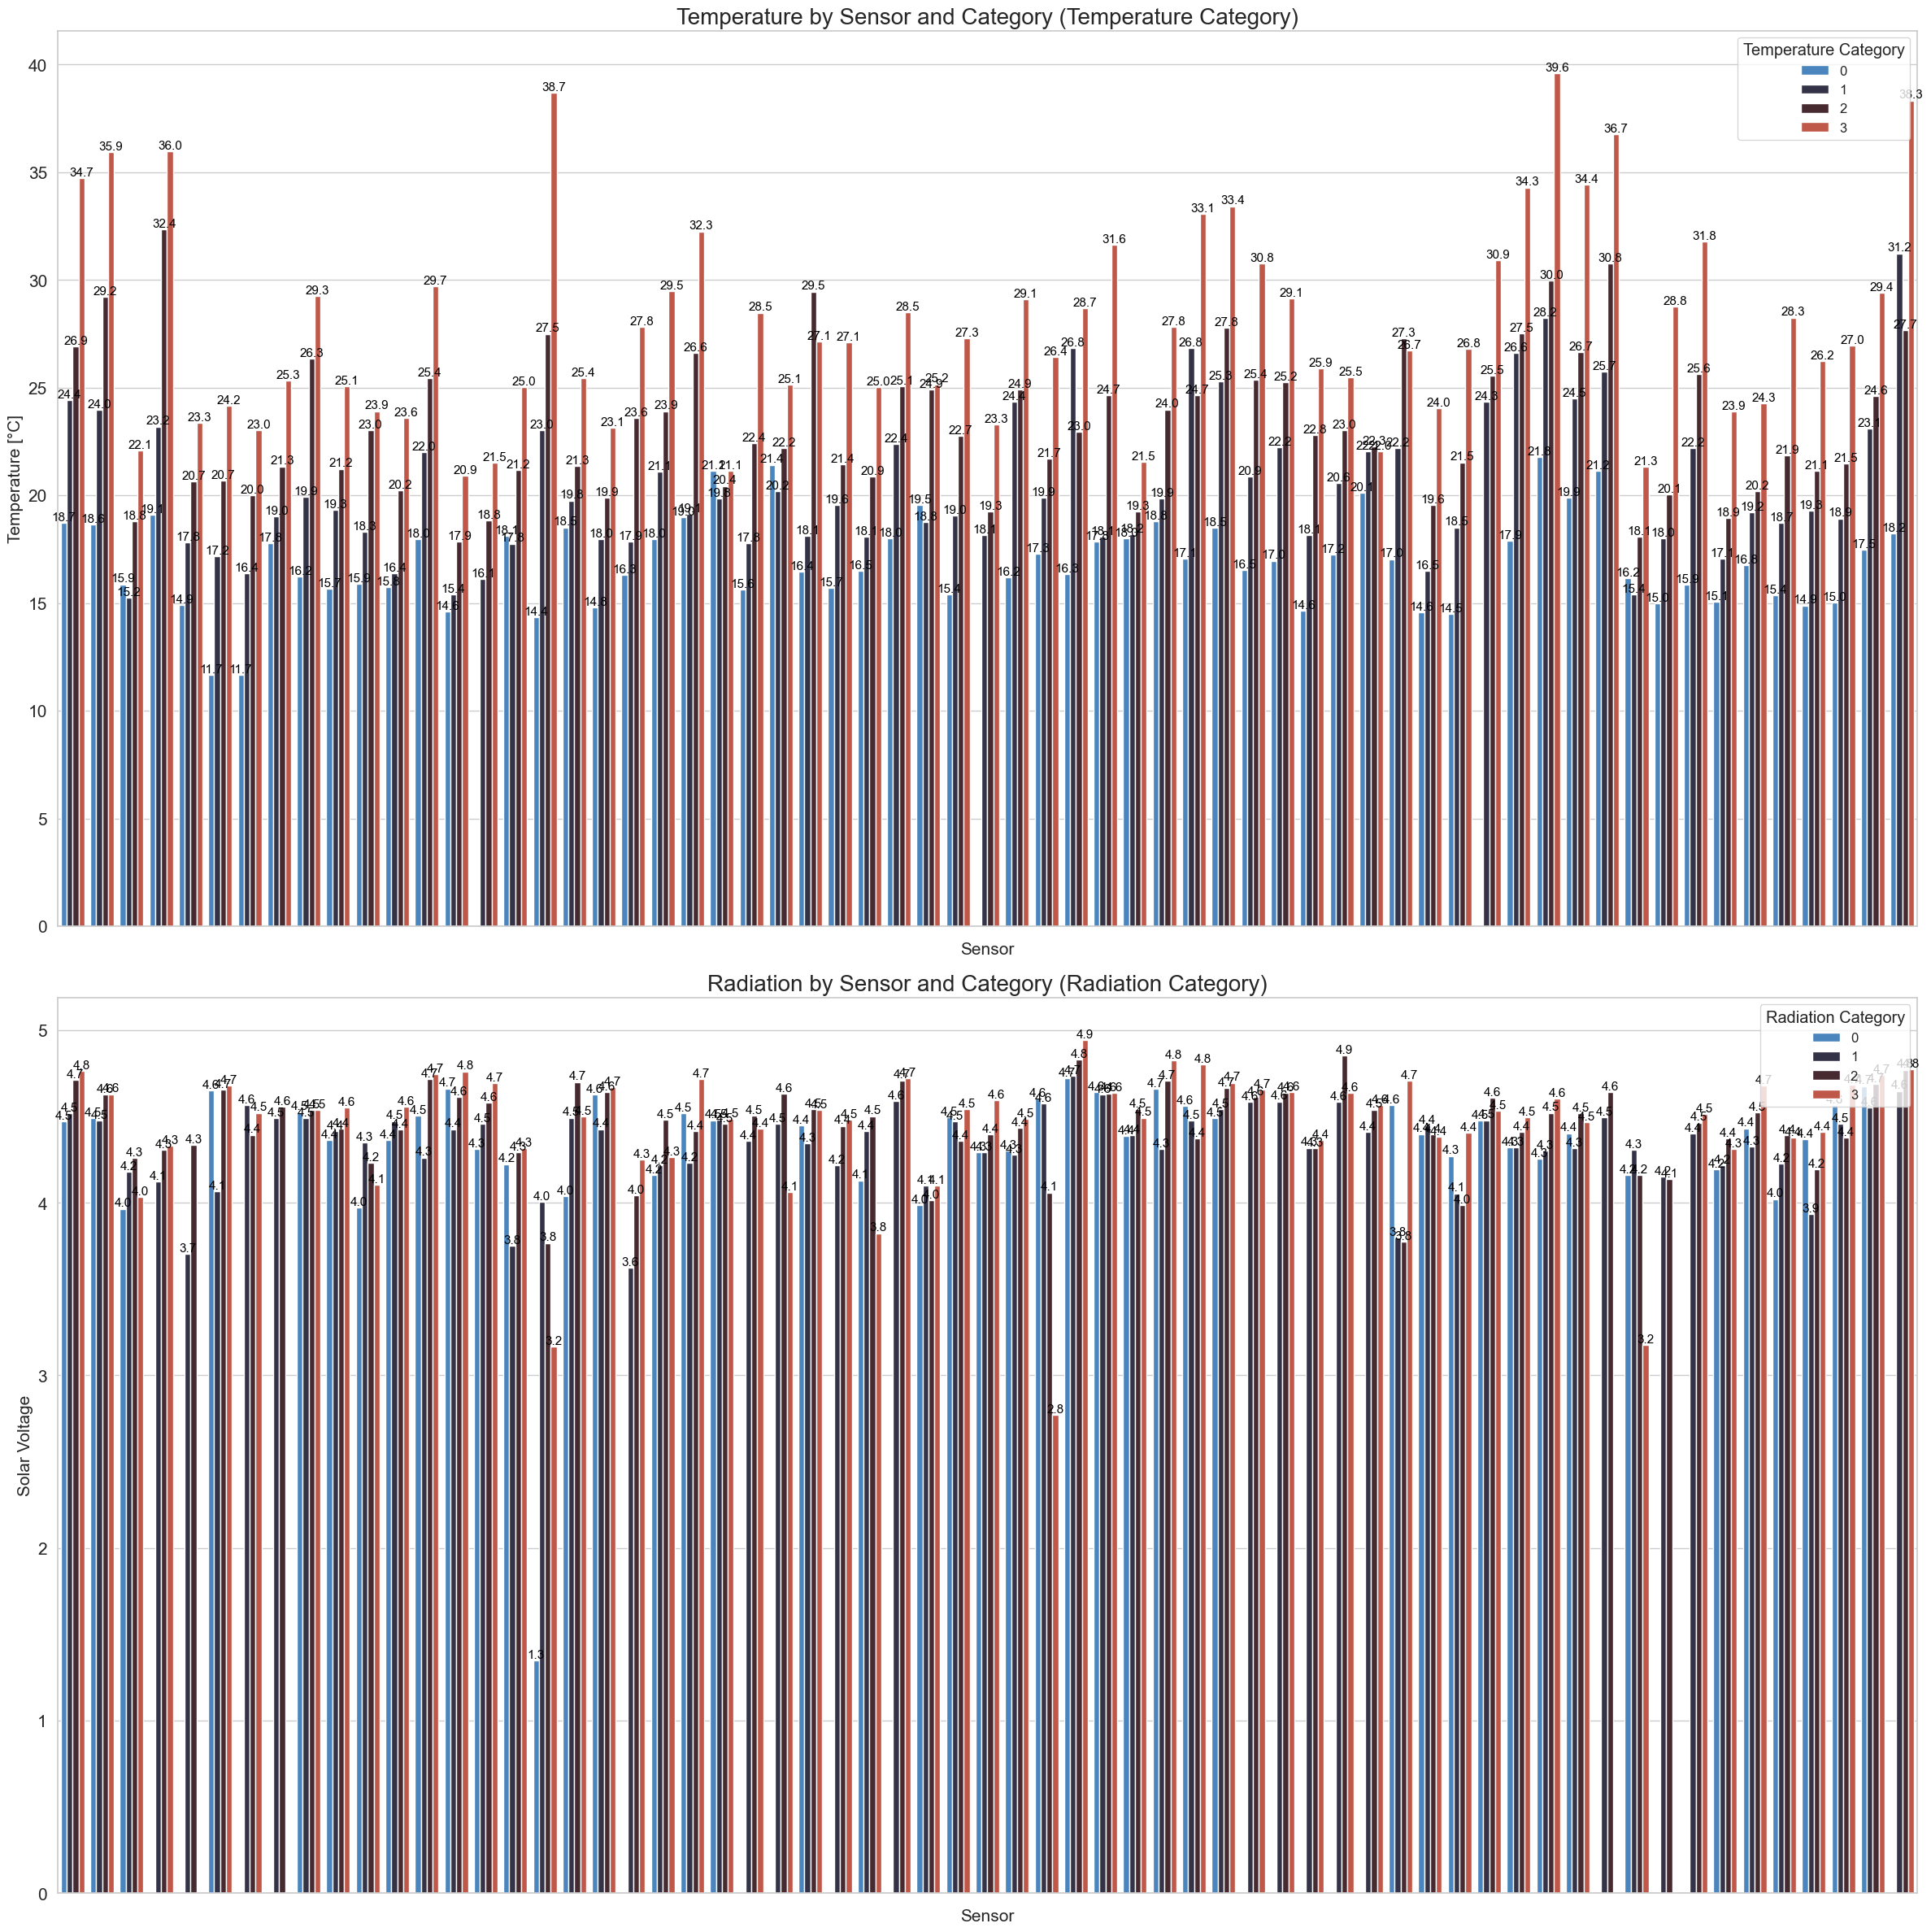

In [20]:
def plot_temperature_and_radiation_by_category(temperature_data, radiation_data):
    """
    Plots temperature and radiation data by categories using bar plots.

    Parameters:
        temperature_data (pd.DataFrame): DataFrame containing temperature data along with sensor and category information.
        radiation_data (pd.DataFrame): DataFrame containing radiation data along with sensor and category information.
    """
    plt.figure(figsize=(24, 24))

    # Plotting temperature data in the first subplot
    plt.subplot(2, 1, 1)
    ax = sns.barplot(x="sensor", y="temperature", data=temperature_data, palette="icefire",
                     hue="temperature_category", errorbar=None, errwidth=3, capsize=0.1, dodge=True, width=0.8)
    plt.xlabel("Sensor", fontsize=15)
    ax.set_xticklabels([])  # Removing x-tick labels for clarity
    plt.ylabel("Temperature [°C]", fontsize=15)
    plt.title("Temperature by Sensor and Category (Temperature Category)", fontsize=20)
    plt.legend(title="Temperature Category", loc='upper right', fontsize=12)
    plt.yticks(fontsize=15)

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.1f}", (p.get_x() + p.get_width() / 2.0, p.get_height()), ha="center",
            va="center", fontsize=11, color="black", xytext=(0, 5), textcoords="offset points"
        )

    # Plotting radiation data in the second subplot
    plt.subplot(2, 1, 2)
    ax = sns.barplot(x="sensor", y="solar_voltage", data=radiation_data, palette="icefire",
                     hue="radiation_category", errorbar=None, errwidth=3, capsize=0.1, dodge=True, width=0.8)
    plt.xlabel("Sensor", fontsize=15)
    plt.ylabel("Solar Voltage", fontsize=15)
    plt.title("Radiation by Sensor and Category (Radiation Category)", fontsize=20)
    plt.legend(title="Radiation Category", loc='upper right', fontsize=12)
    ax.set_xticklabels([])  # Removing x-tick labels for clarity
    plt.yticks(fontsize=15)

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.01f}", (p.get_x() + p.get_width() / 2.0, p.get_height()), ha="center",
            va="center", fontsize=11, color="black", xytext=(0, 5), textcoords="offset points"
        )

    plt.tight_layout()
    plt.savefig("../plots/temperature_radiation_by_category.png")
    plt.show()


plot_temperature_and_radiation_by_category(merged_df_temperature, merged_df_radiation)

---
## Part 4: Data Clustering
---
*This section prepares data for clustering through cleaning, standardization, and dimensionality reduction via PCA, leading to clusters that reflect dataset patterns.*

### 4.1 Data Preprocessing and PCA Transformation for Clustering
*This section of the notebook is dedicated to the preprocessing and PCA (Principal Component Analysis) transformation of data, setting the stage for effective clustering. The process involves several key steps:*

1. **Melt Data Based on Mode:** Transforming the dataset from a wide to a long format, with each row representing a sensor measurement and categorized by the mode (such as temperature or radiation).

2. **Data Cleaning:** Removing any non-numeric entries and handling missing values to ensure data integrity and consistency.

3. **Standardizing Data:** Scaling the data so that each feature has a mean of zero and a standard deviation of one. This standardization is crucial for unbiased PCA and clustering analysis.

4. **PCA and Scree Plot:** Performing Principal Component Analysis to reduce the dimensionality of the data. A scree plot is used to determine the optimal number of principal components to retain, striking a balance between simplifying the dataset and preserving its variance.

5. **Outputting PCA-Transformed Data:** The final output of this step is the PCA-transformed data, ready for clustering.

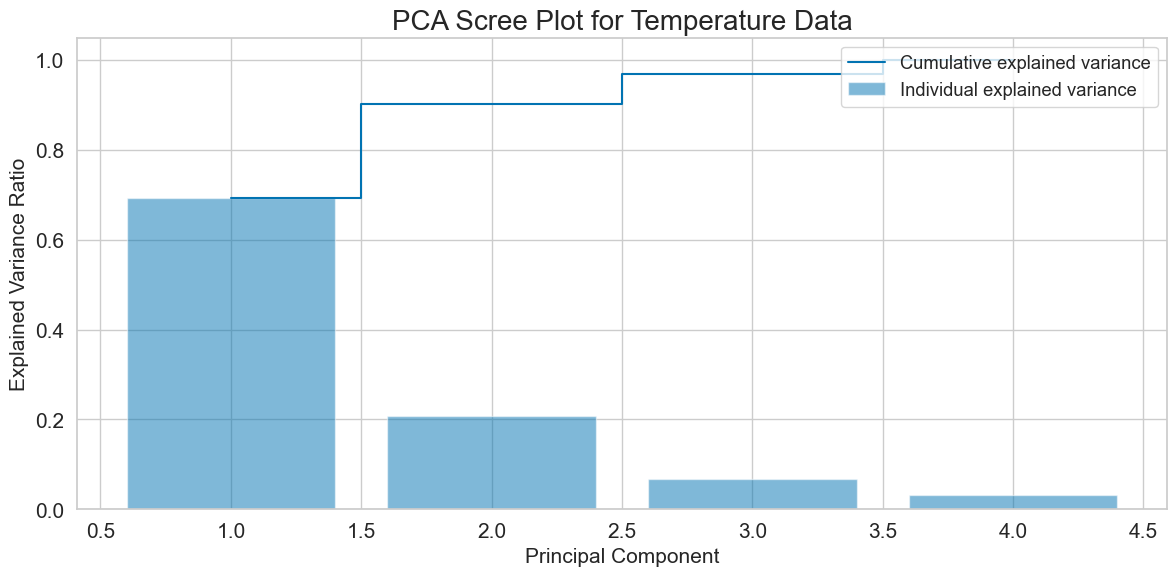

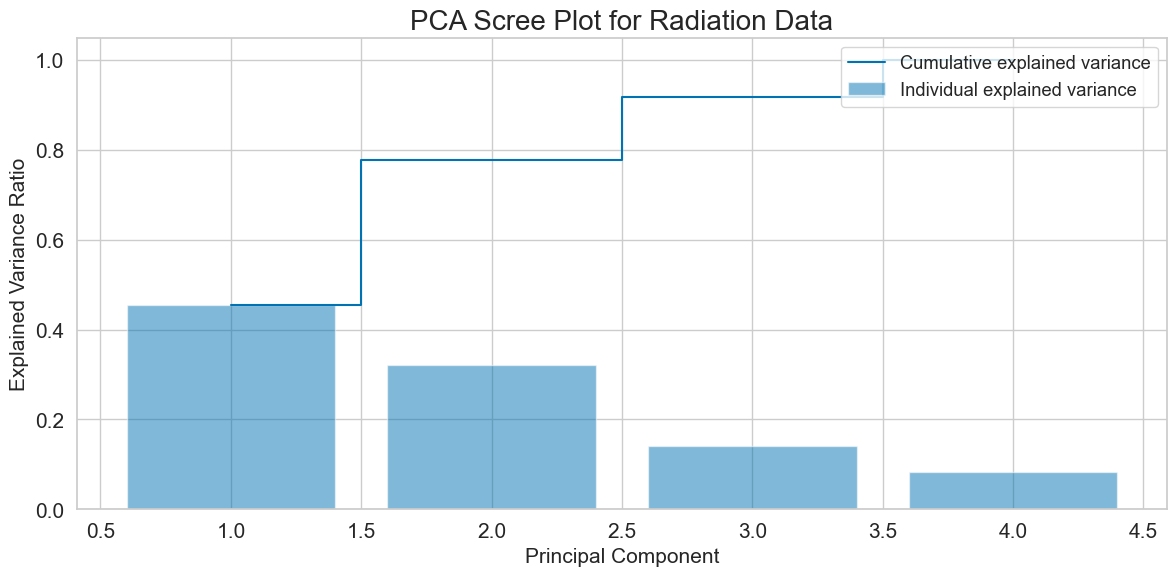

In [21]:
def clean_data(data):
    """
    Cleans the data by selecting only numeric data and dropping missing values.

    Parameters:
        data (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: A DataFrame with only numeric data.
    """
    return data.select_dtypes(include=[np.number]).dropna()


def plot_scree_plot(data, mode):
    """
    Plots the scree plot to determine the number of principal components to retain.

    Parameters:
        data (pd.DataFrame): The DataFrame whose PCA is to be performed.
        mode (str): The mode of data ('Temperature' or 'Radiation').
    """
    # Fit PCA and calculate variance ratios
    pca = PCA(random_state=42).fit(data)
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.5, align='center',
            label='Individual explained variance')
    plt.step(range(1, len(cumulative_var) + 1), cumulative_var, where='mid', label='Cumulative explained variance')
    plt.xlabel('Principal Component', fontsize=15)
    plt.ylabel('Explained Variance Ratio', fontsize=15)
    plt.legend(loc='upper right')
    plt.title(f"PCA Scree Plot for {mode} Data", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig(f"../plots/pca_scree_plot_{mode}.png")
    plt.show()
    plt.close()


def prepare_data_for_clustering(data_frame, n_components, mode):
    """
    Performs data preprocessing and PCA transformation for clustering.

    Parameters:
        data_frame (pd.DataFrame): The DataFrame to be processed.
        mode (str): The mode of data ('Temperature' or 'Radiation').

    Returns:
        np.ndarray: PCA-transformed data.
    """
    try:
        data, merged_df = melt_data(data_frame, mode)
        cleaned_data = clean_data(data)
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(cleaned_data)
        plot_scree_plot(scaled_data, mode)
        pca = PCA(n_components=n_components, random_state=42)
        pca_transformed_data = pca.fit_transform(scaled_data)

        return pca_transformed_data, cleaned_data, scaler, pca

    except Exception as e:
        print(f"Error in prepare_data_for_clustering: {e}")


# Applying the function to temperature and radiation data
pca_transformed_data_temperature, cleaned_data_temperature, scaler_temperature, pca_temperature = prepare_data_for_clustering(
    resulting_data, n_components=0.95, mode="Temperature")
pca_transformed_data_radiation, cleaned_data_radiation, scaler_radiation, pca_radiation = prepare_data_for_clustering(
    resulting_data, n_components=0.95, mode="Radiation")


### Comprehensive Data Clustering Pipeline for Sensor Data Analysis
*This section outlines a detailed data clustering pipeline, which plays an important role in analyzing sensor data to uncover underlying patterns. The pipeline encompasses a range of critical functions, each contributing to different stages of the clustering process:*

1. **Data Preprocessing:** Prepares the raw sensor data by cleaning and standardizing it, ensuring it is suitable for effective clustering.

2. **PCA Transformation:** Implements Principal Component Analysis to reduce data dimensionality, making clustering more manageable and insightful.

3. **Hierarchical Clustering and Dendrogram Plotting:** Applies hierarchical clustering to the data and visualizes the clustering hierarchy through dendrograms, providing a preliminary view of data groupings.

4. **KMeans and DBSCAN Clustering:** Utilizes popular clustering algorithms like KMeans and DBSCAN to categorize the data into distinct clusters.

5. **PCA Results Visualization:** Plots the results of PCA, offering a visual representation of data spread and cluster separations.

6. **Model and Scaler Preservation:** Saves trained clustering models and scalers for future use, ensuring consistency in subsequent analyses.

7. **Cluster Feature and Statistical Analysis:** Analyzes the features and computes statistical measures for each cluster, aiding in the understanding of each cluster's characteristics.

8. **Custom Functions for Modularity:** Incorporates custom functions for silhouette scoring, hierarchical clustering, dendrogram plotting, and cluster analysis, enhancing the code's modularity and readability.

9. **Cluster Label Analysis and Visualization:** Involves reversing sensor-to-cluster mappings, updating cluster labels based on mean values, and plotting cluster label distributions alongside their statistical measures.

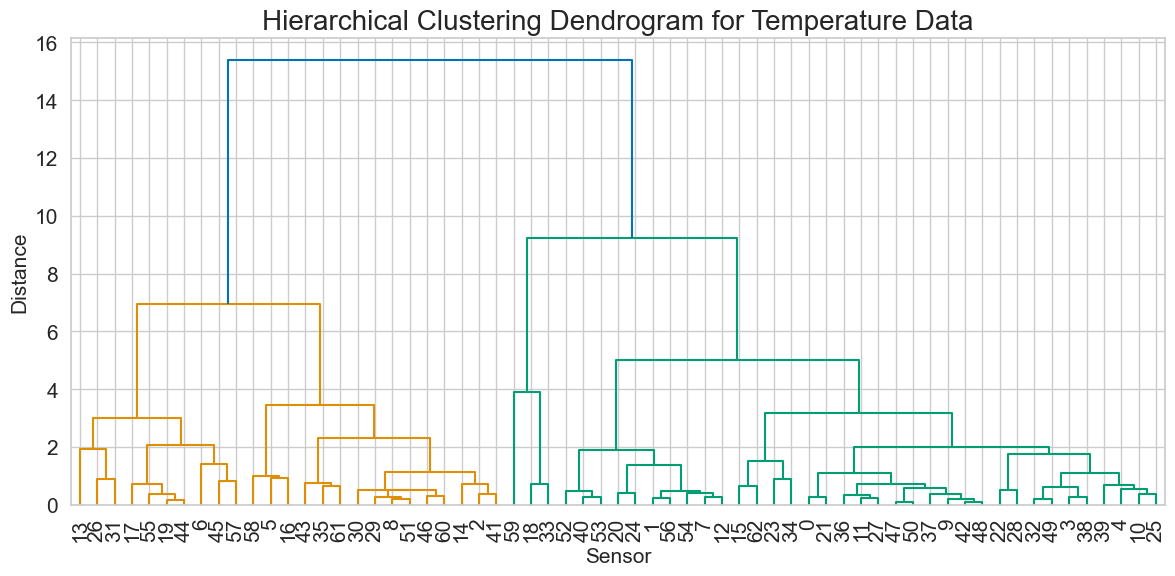

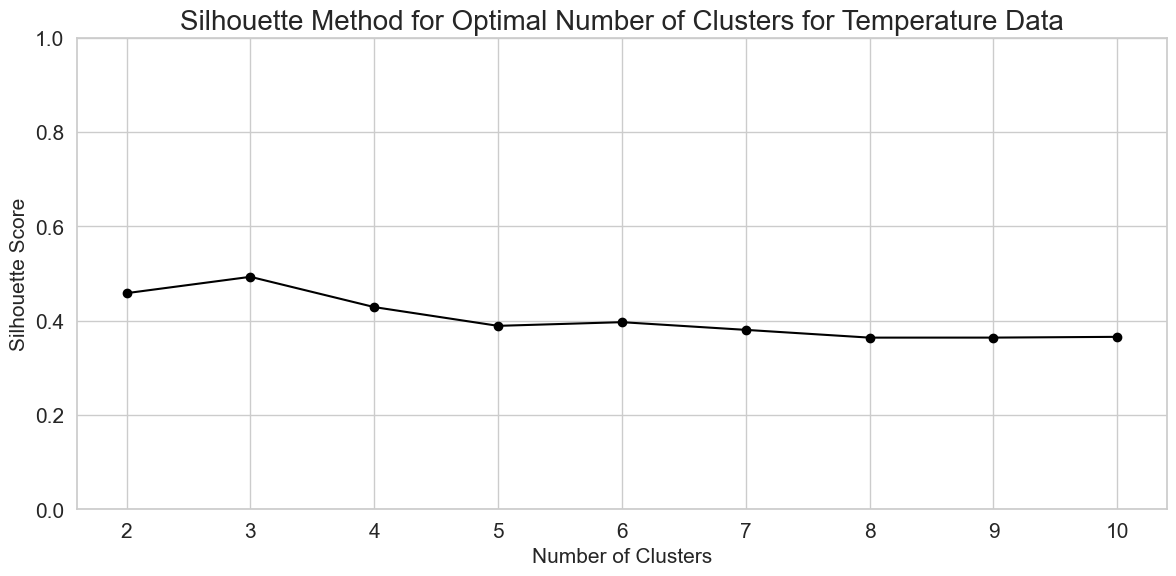

Optimal number of clusters for Temperature: 3


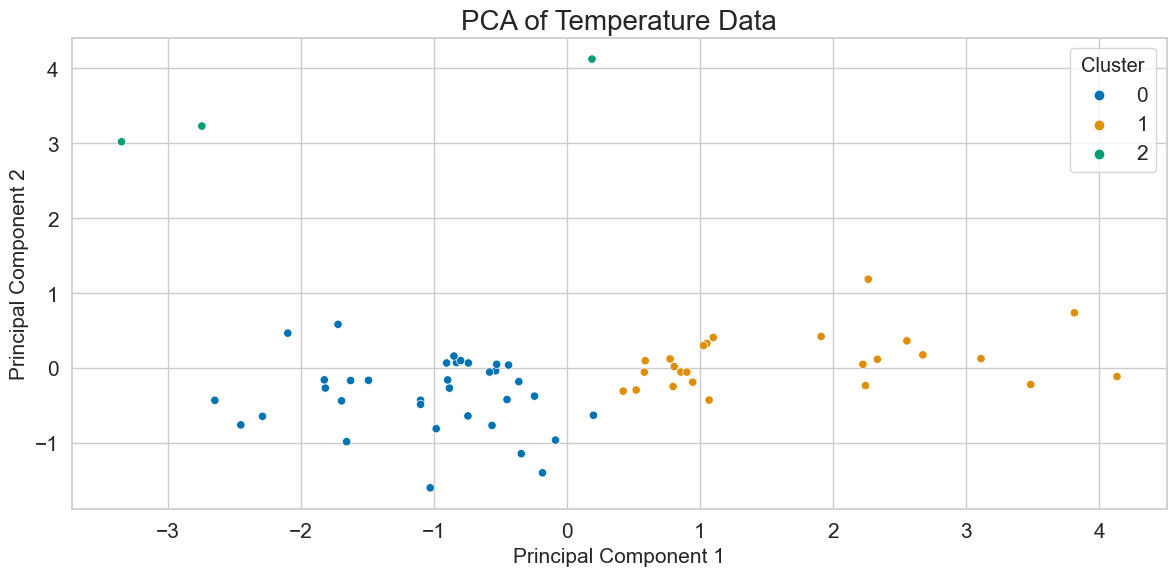

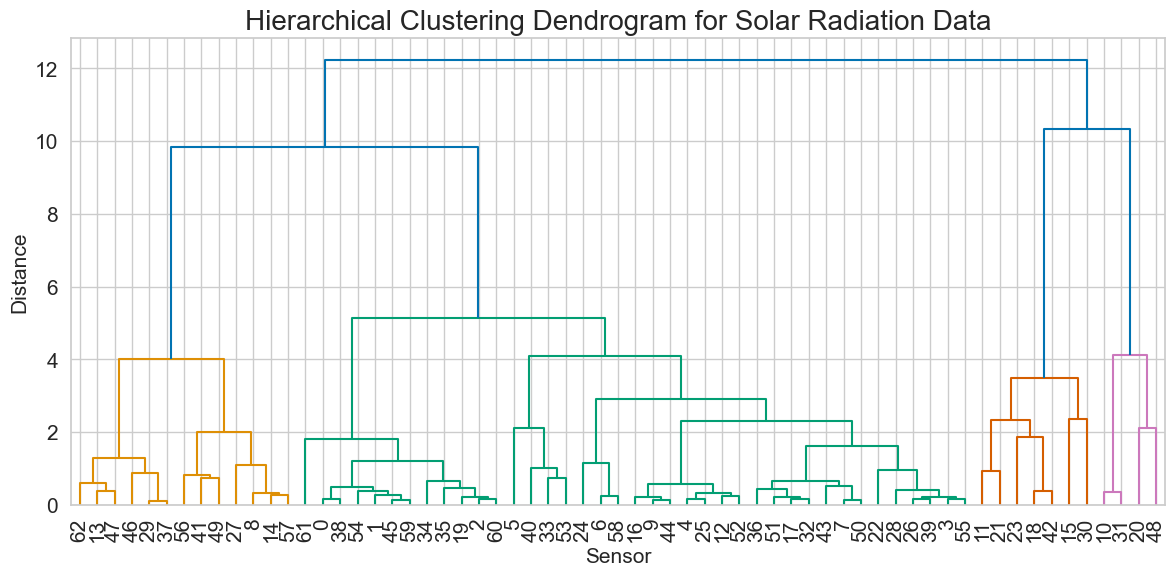

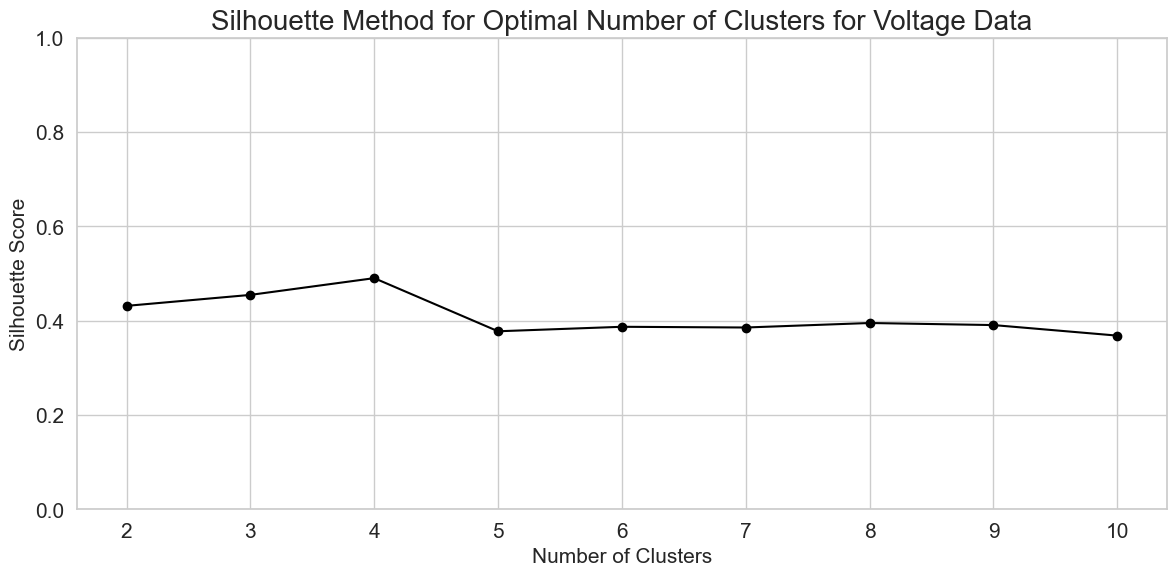

Optimal number of clusters for Radiation: 4


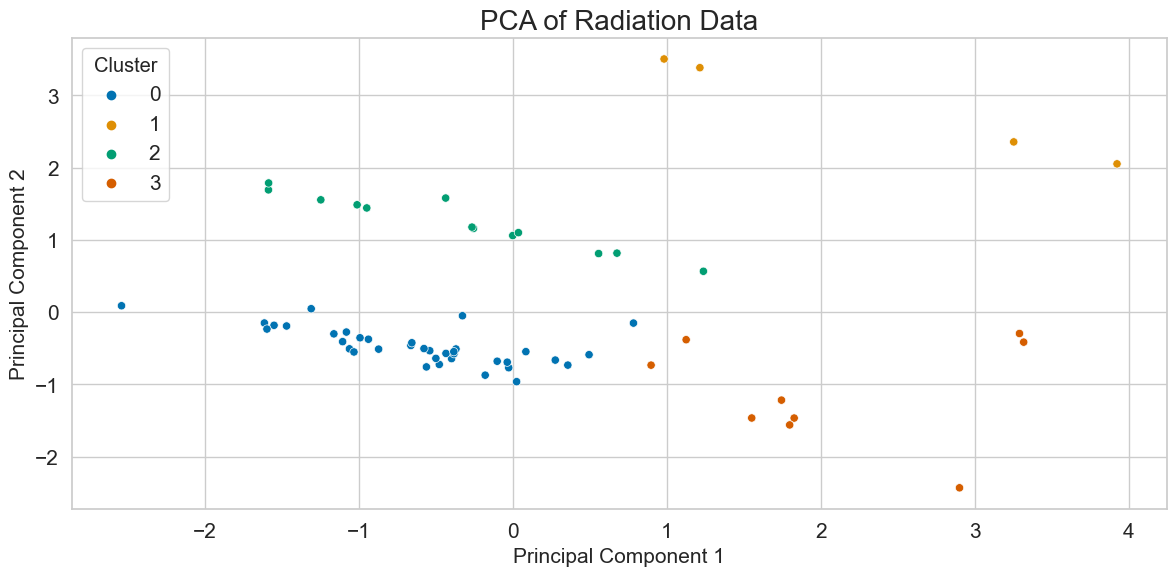

In [22]:
def plot_silhouette_scores(cluster_range, scores, mode):
    """
    Plots the silhouette scores for a range of cluster counts.

    Parameters:
        cluster_range (range): The range of cluster counts to evaluate.
        scores (list): Silhouette scores for each cluster count.
        mode (str): 'Temperature' or 'Radiation', indicating the dataset type.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, scores, 'o-', color="black")
    mode_title = 'Temperature' if mode == 'Temperature' else 'Voltage'
    plt.title(f"Silhouette Method for Optimal Number of Clusters for {mode_title} Data", fontsize=20)
    plt.xlabel("Number of Clusters", fontsize=15)
    plt.ylabel("Silhouette Score", fontsize=15)
    plt.xticks(cluster_range, fontsize=15)
    plt.grid(True)
    plt.ylim(0, 1)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig(f"../plots/Silhouette_Method_Optimal_Number_of_Clusters_{mode}.png")
    plt.show()


def perform_hierarchical_clustering(data, mode):
    """
    Performs hierarchical clustering on the given dataset and plots a dendrogram.

    Parameters:
        data (np.ndarray): Dataset for clustering.
        mode (str): 'Temperature' or 'Radiation'.
    """
    linkage_matrix = hierarchy.linkage(data, method="ward")
    plot_dendrogram(linkage_matrix, mode)


def plot_dendrogram(linkage_matrix, mode):
    """
    Plots a dendrogram for hierarchical clustering results.

    Parameters:
        linkage_matrix: Linkage matrix from hierarchical clustering.
        mode (str): 'Temperature' or 'Radiation'.
    """
    plt.figure(figsize=(12, 6))
    hierarchy.dendrogram(linkage_matrix, orientation="top", leaf_font_size=10)
    mode_title = 'Temperature' if mode == 'Temperature' else 'Solar Radiation'
    plt.xlabel("Sensor", fontsize=15)
    plt.ylabel("Distance", fontsize=15)
    plt.title(f"Hierarchical Clustering Dendrogram for {mode_title} Data", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig(f"../plots/hierarchical_clustering_{mode_title}.png")
    plt.show()


def apply_kmeans(data, mode, cluster_range=(2, 11)):
    """
    Applies KMeans clustering to the dataset and plots silhouette scores.

    Parameters:
        data (np.ndarray): Dataset for clustering.
        mode (str): 'Temperature' or 'Radiation'.
        cluster_range (tuple): Range of cluster numbers to try.

    Returns:
        KMeans object: Fitted KMeans model.
    """
    silhouette_scores = []
    for num_clusters in range(*cluster_range):
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=100).fit(data)
        cluster_labels = kmeans.predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    plot_silhouette_scores(range(*cluster_range), silhouette_scores, mode)
    optimal_number_of_clusters = cluster_range[0] + silhouette_scores.index(max(silhouette_scores))
    print(f"Optimal number of clusters for {mode}: {optimal_number_of_clusters}")
    return KMeans(n_clusters=optimal_number_of_clusters, random_state=42, n_init=100).fit(data)


def plot_pca_results(pca_transformed_data, cleaned_data, mode):
    """
    Plots the results of PCA transformation with cluster labels.

    Parameters:
        pca_transformed_data (np.ndarray): PCA-transformed dataset.
        cleaned_data (pd.DataFrame): DataFrame with cluster labels.
        mode (str): 'Temperature' or 'Radiation'.
    """
    pca_df = pd.DataFrame(data=pca_transformed_data[:, :2], columns=['PC1', 'PC2'])
    pca_df['cluster'] = cleaned_data['cluster'].values
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='colorblind')
    plt.title(f'PCA of {mode} Data', fontsize=20)
    plt.xlabel('Principal Component 1', fontsize=15)
    plt.ylabel('Principal Component 2', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(title='Cluster', fontsize=15)
    plt.tight_layout()
    plt.savefig(f"../plots/pca_results_{mode}.png")
    plt.show()


def perform_clustering(data, cleaned_data, pca_transformed_data, mode):
    """
    Performs clustering on the given dataset using KMeans.

    Parameters:
        data (pd.DataFrame): Original dataset.
        cleaned_data (pd.DataFrame): Cleaned dataset.
        pca_transformed_data (np.ndarray): PCA-transformed data.
        mode (str): 'Temperature' or 'Radiation'.

    Returns:
        tuple: Cluster model, cluster labels, and data.
    """
    perform_hierarchical_clustering(pca_transformed_data, mode)

    cluster_model = apply_kmeans(pca_transformed_data, mode)

    cleaned_data['cluster'] = cluster_model.labels_
    cluster_labels = cleaned_data["cluster"].to_dict()

    plot_pca_results(pca_transformed_data, cleaned_data, mode)

    return cluster_model, cluster_labels, data


# Apply the clustering function to temperature data
temperature_clusters, temperature_cluster_labels, data_temperature = perform_clustering(
    resulting_data, cleaned_data_temperature, pca_transformed_data_temperature,
    mode="Temperature")

# Apply the clustering function to radiation data
radiation_clusters, radiation_cluster_labels, data_radiation = perform_clustering(
    resulting_data, cleaned_data_radiation, pca_transformed_data_radiation,
    mode="Radiation")

---
## Part 5: Processing Clustered Data
---
*This section focuses on the post-clustering processing of data, including saving models for future inference, plotting cluster features, updating cluster labels, and analyzing cluster characteristics.*


### 5.1: Saving Trained Models and Scalers for Future Use
*This code saves trained models and their scalers. This step is important for enabling these models to be later used for inference on new data, ensuring consistency in data scaling and model application.*


In [23]:
# Save the temperature scaler to a file for later use.
# This allows the scaler to be applied to new data that needs to be processed in the same way as the training data
joblib.dump(scaler_temperature, "../model/temperature_scaler.pkl")

# Save the temperature model
# This saved model can be used to predict the cluster of new temperature data points
joblib.dump(temperature_clusters, "../model/temperature_clusters.pkl")

# Save the radiation scaler
joblib.dump(scaler_radiation, "../model/radiation_scaler.pkl")

# Save the radiation model
joblib.dump(radiation_clusters, "../model/radiation_clusters.pkl")

['../model/radiation_clusters.pkl']

### 5.2: Analyzing Cluster Features and Statistical Measures
*The code is dedicated to visualizing the characteristics of each cluster and computing key statistical measures. It includes plotting data for sensors in box plots and calculating metrics like mean, standard deviation, and range, providing a comprehensive statistical overview of each cluster.*


In [24]:
boum_data.set_index('timestamp', inplace=True)
boum_data = boum_data[(boum_data.index.month >= 4) & (boum_data.index.month <= 10)] # Select the months April to October
boum_data = boum_data[(boum_data.index.hour >= min_time) & (boum_data.index.hour <= max_time)] # Select the maximum variability hours

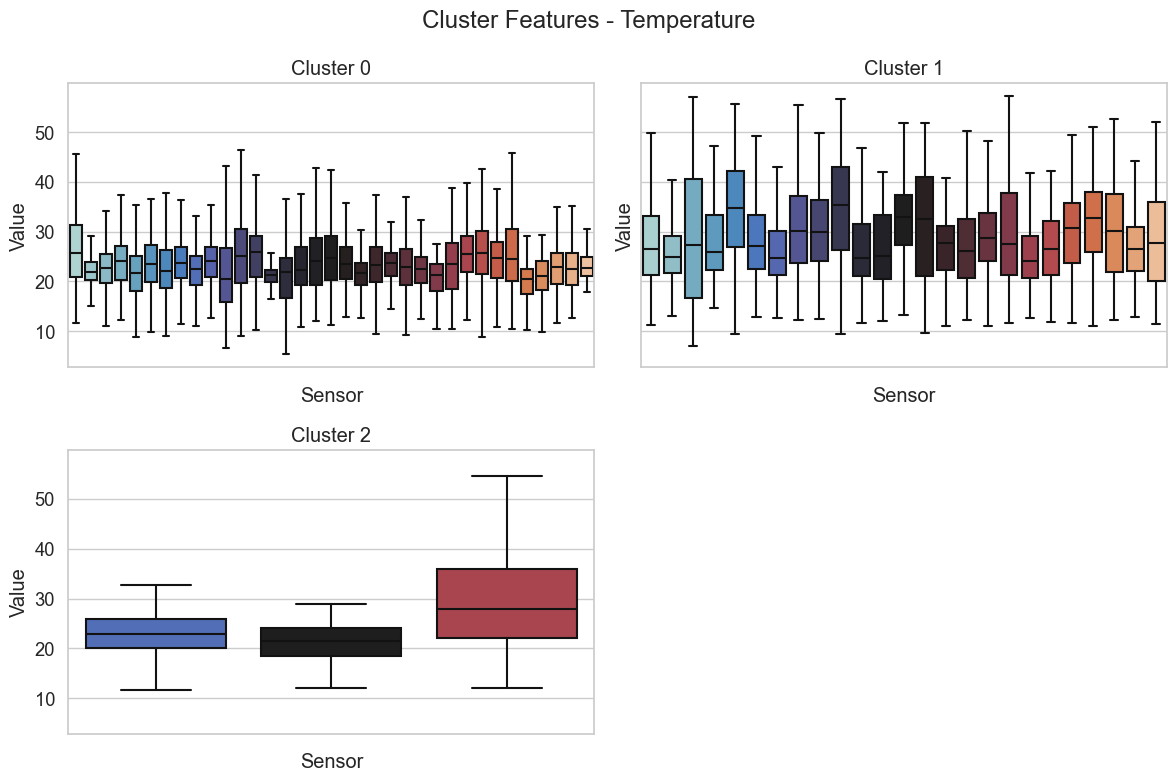

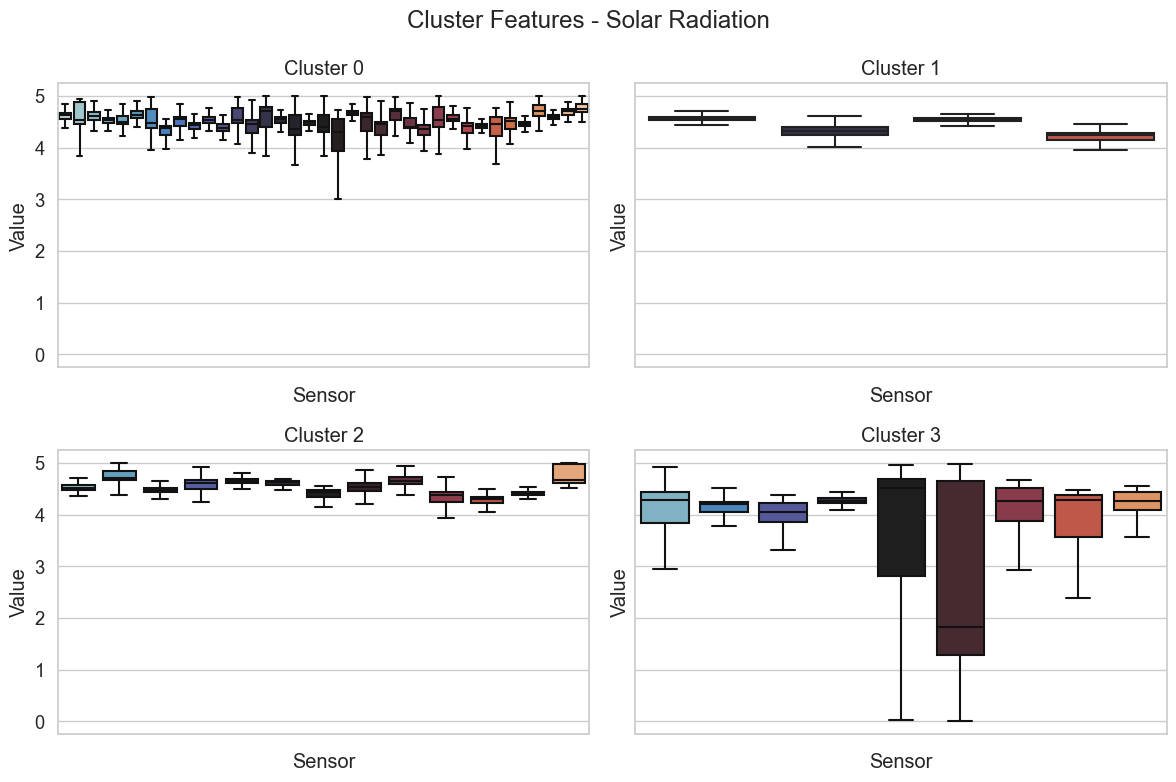

In [25]:
def reverse_cluster_mapping(clustered_data):
    """
    Reverses the mapping of sensors to clusters, creating a dictionary where each key is a cluster, and the value is a list of sensors in that cluster.

    Parameters:
        clustered_data (dict): A dictionary mapping each sensor to its cluster.

    Returns:
        dict: Dictionary with clusters as keys and lists of sensors as values.
    """
    return {cluster: [sensor for sensor, cluster_id in clustered_data.items() if cluster_id == cluster] for cluster in
            set(clustered_data.values())}


def plot_cluster_features(sorted_clusters, result_data, mode="Temperature"):
    """
    Plots the features of each cluster.

    Parameters:
        sorted_clusters (dict): Dictionary with clusters as keys and lists of sensors as values.
        result_data (pd.DataFrame): DataFrame containing the sensor data.
        mode (str): Mode of data ('Temperature' for temperature or 'Radiation' for radiation).
    """
    num_clusters = len(sorted_clusters)
    grid_size = int(np.ceil(np.sqrt(num_clusters)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 8), sharey="all")
    axes = axes.flatten()
    result_data.index = pd.to_datetime(result_data.index)

    for i, (cluster, sensors) in enumerate(sorted_clusters.items()):
        if sensors:
            cluster_data = result_data.loc[:, sensors]
            sns.boxplot(data=cluster_data, ax=axes[i], palette="icefire", showfliers=False)
            axes[i].set_title(f"Cluster {cluster}")
            axes[i].set_xticklabels([])
            axes[i].set_xlabel("Sensor")
            axes[i].set_ylabel("Value")

    # Remove unused subplots
    for j in range(i + 1, grid_size ** 2):
        fig.delaxes(axes[j])

    plt.suptitle("Cluster Features" + (" - Temperature" if mode == "Temperature" else " - Solar Radiation"))
    plt.tight_layout()
    plt.savefig(f"../plots/cluster_features_{mode}.png")
    plt.show()


def calculate_cluster_statistics(sorted_clusters, result_data):
    """
    Calculates statistical measures for each cluster.

    Parameters:
        sorted_clusters (dict): Dictionary with clusters as keys and lists of sensors as values.
        result_data (pd.DataFrame): DataFrame containing the sensor data.

    Returns:
        pd.DataFrame: DataFrame containing the calculated statistics for each cluster.
    """
    statistics = []
    for cluster, sensors in sorted_clusters.items():
        if sensors:
            cluster_data = result_data.loc[:, sensors]
            statistics.append({
                "Sensor": sorted_clusters[cluster],
                "Cluster": cluster,
                "Mean": cluster_data.mean(axis=1).mean(),
                "Std": cluster_data.std().mean(),
                "Max": cluster_data.max().mean(),
                "Min": cluster_data.min().mean(),
                "Range": cluster_data.max().mean() - cluster_data.min().mean()
            })

    return pd.DataFrame(statistics)


def visualize_clusters(cluster_data, result_data, mode):
    """
    Visualizes clusters and calculates their statistics.

    Parameters:
        cluster_data (dict): A dictionary mapping each sensor to its cluster.
        result_data (pd.DataFrame): DataFrame containing the sensor data.
        mode (str): Mode of data ('Temperature' for temperature or 'Radiation' for radiation).

    Returns:
        pd.DataFrame: DataFrame containing the calculated statistics for each cluster.
    """
    if 'timestamp' in result_data.columns:
        result_data.set_index('timestamp', inplace=True)

    sorted_clusters = reverse_cluster_mapping(cluster_data)
    if not sorted_clusters:
        print("No clusters to visualize.")
        return pd.DataFrame()

    plot_cluster_features(sorted_clusters, result_data, mode)
    return calculate_cluster_statistics(sorted_clusters, result_data)


df_temperature_all = visualize_clusters(temperature_cluster_labels, boum_data, "Temperature")
df_radiation_all = visualize_clusters(radiation_cluster_labels, boum_data, "Radiation")

*Define the cluster labels*

In [26]:
temperature_labels = ["cool", "warm", "hot"]
radiation_labels = ["dark", "medium dark", "medium bright", "bright"]

### 5.4: Updating Cluster Labels Based on Mean Values
*This segment updates cluster labels in a DataFrame based on their mean values. By sorting the DataFrame, mapping means to the labels, and updating labels, it adds interpretive value to the clusters, helping in the identification of patterns and anomalies.*


In [27]:
def update_cluster_labels(data_frame, labels):
    """
    Updates the cluster labels in the DataFrame based on their mean values.

    Parameters:
        data_frame (pd.DataFrame): DataFrame containing cluster statistics.
        labels (list): List of labels to assign to each cluster.

    Returns:
        tuple: Original DataFrame and the updated DataFrame with new cluster labels.
    """
    if len(data_frame["Cluster"].unique()) != len(labels):
        raise ValueError("Number of labels does not match the number of clusters.")

    # Sorting the DataFrame by the mean values of each cluster
    sorted_clusters = data_frame.sort_values(by="Mean", ascending=True)["Cluster"].unique()
    # Creating a mapping from original cluster labels to new labels
    label_mapping = {cluster: label for cluster, label in zip(sorted_clusters, labels)}
    print("Cluster to Label Mapping:", label_mapping)

    # Applying the new labels to the DataFrame
    data_frame['new_label'] = data_frame['Cluster'].map(label_mapping)
    original_data_frame = data_frame.copy()
    data_frame = data_frame.explode("Sensor")

    return original_data_frame, data_frame


# Updating cluster labels for temperature and radiation data
df_temperature_all_org, df_temperature_all_updated = update_cluster_labels(df_temperature_all, temperature_labels)
df_radiation_all_org, df_radiation_all_updated = update_cluster_labels(df_radiation_all, radiation_labels)


Cluster to Label Mapping: {0: 'cool', 2: 'warm', 1: 'hot'}
Cluster to Label Mapping: {3: 'dark', 1: 'medium dark', 0: 'medium bright', 2: 'bright'}


### 5.6: Plotting Cluster Label Distribution and Statistical Analysis
*This section plots the distribution of cluster labels and calculates statistical measures for each cluster. It employs functions like `plot_label_distribution` for visualization and `calculate_cluster_statistics` for measuring key statistical parameters, thereby offering a detailed insight into the cluster distribution and characteristics.*


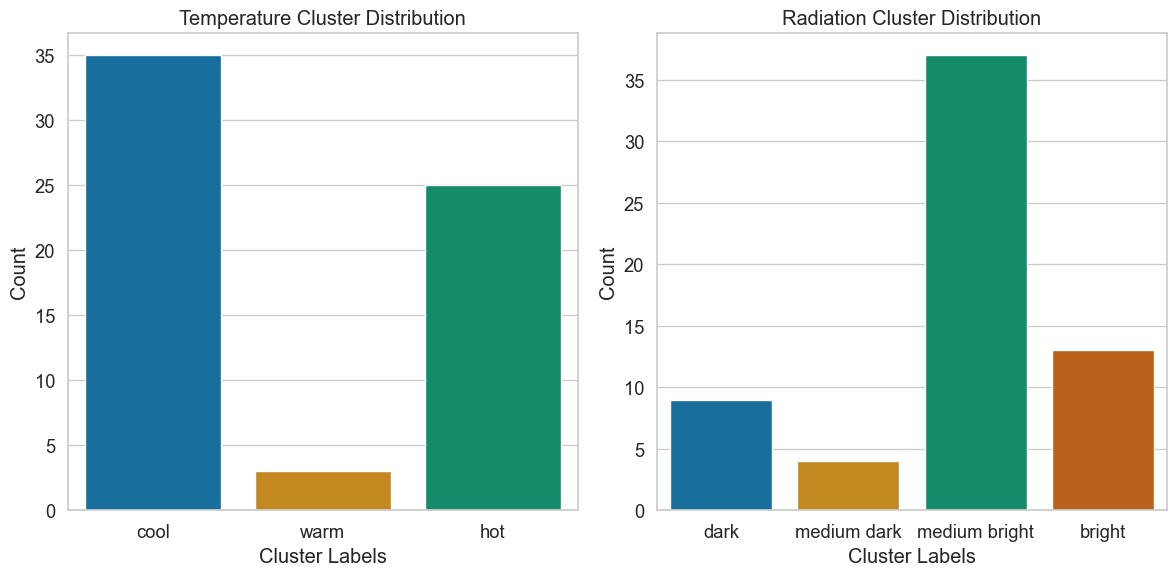

In [28]:
def plot_label_distribution(df, column, labels, title, ax):
    """
    Plots the distribution of labels in a given DataFrame column.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        column (str): The column in the DataFrame to plot.
        labels (list): List of labels to include in the plot.
        title (str): Title of the plot.
        ax (matplotlib.axes._subplots.AxesSubplot): The axes on which to plot.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    sns.countplot(x=column, data=df, order=labels, ax=ax, alpha=1)
    ax.set_title(title)
    ax.set_xlabel('Cluster Labels')
    ax.set_ylabel('Count')


def plot_distribution():
    """
    Plots the distribution of temperature and radiation cluster labels.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plot_label_distribution(df_temperature_all_updated, 'new_label', temperature_labels,
                            'Temperature Cluster Distribution', axes[0])
    plot_label_distribution(df_radiation_all_updated, 'new_label', radiation_labels, 'Radiation Cluster Distribution',
                            axes[1])
    plt.tight_layout()
    plt.savefig("../plots/cluster_labels.png")
    plt.show()


plot_distribution()

In [29]:
# Print the number of locations in each cluster.
print(df_temperature_all_updated.value_counts('new_label'))
print(df_radiation_all_updated.value_counts('new_label'))

new_label
cool    35
hot     25
warm     3
Name: count, dtype: int64
new_label
medium bright    37
bright           13
dark              9
medium dark       4
Name: count, dtype: int64


*Define temperature_columns and radiation_columns*

In [30]:
temperature_columns = [col for col in df_temperature_all_updated["Sensor"] if col.startswith("temperature_boum")]
voltage_columns = [col.replace("temperature", "solarVoltage") for col in temperature_columns]

---
## Part 6: Cluster Features and Statistics Analysis
---
*This section calculates statistical measures for each cluster, visualizes label distribution, and examines cluster features in depth.*


### 6.1: Calculating Statistical Measures for Each Cluster
*Focuses on the computation of statistical measures for each cluster. This step is pivotal in understanding the underlying data distribution and cluster characteristics.*


In [31]:
def calculate_new_cluster_statistics(df, df_all, data_columns, result_prefix):
    """
    Calculate cluster statistics for given data columns.

    Parameters:
        df (pd.DataFrame): DataFrame containing data columns.
        df_all (pd.DataFrame): DataFrame containing cluster information.
        data_columns (list): List of data columns to calculate statistics.
        result_prefix (str): Prefix to add to result column names.
    
    Returns:
        pd.DataFrame: DataFrame with calculated statistics.
    """
    # Calculate statistics for data columns
    statistics = df[data_columns].agg(
        ["min", "max", "mean", "std"]).transpose()
    statistics.columns = [f"{result_prefix}_{col}" for col in statistics.columns]
    statistics = statistics.reset_index().rename(columns={"index": "Sensor"})

    # Merge with cluster information
    statistics = pd.merge_ordered(statistics, df_all[["Sensor", "Cluster", "new_label"]], on="Sensor").rename(
        columns={"Cluster": f"Cluster_{result_prefix}", "new_label": f"Cluster_{result_prefix}_label"})
    statistics["Sensor"] = statistics["Sensor"].str[-8:]
    return statistics


def calculate_monthly_cluster_statistics(data_frame, month_column, months):
    """
    Calculate monthly cluster statistics for given data columns.

    Parameters:
        data_frame (pd.DataFrame): DataFrame containing data columns.
        month_column (str): Column containing month information.
        months (list): List of months to calculate statistics for.

    Returns:
        list: List of DataFrames containing monthly statistics.
    """
    monthly_data_frames = []
    for month in months:
        month_data = data_frame[data_frame[month_column] == month]
        if not month_data.empty:
            df_temp_month = calculate_new_cluster_statistics(
                month_data,
                df_temperature_all_updated,
                temperature_columns,
                f"temperature_{month}",
            )
            df_dni_month = calculate_new_cluster_statistics(
                month_data,
                df_radiation_all_updated,
                voltage_columns,
                f"voltage_{month}",
            )
            df_combined_month = pd.merge_ordered(df_temp_month, df_dni_month, on="Sensor")
            monthly_data_frames.append(df_combined_month)
        else:
            print(f"No data for month {month}")
    return monthly_data_frames


# Calculate cluster statistics for temperature and solar data
df_combined_temperature = calculate_new_cluster_statistics(
    boum_data, df_temperature_all_updated, temperature_columns, "temperature"
)
df_combined_solar = calculate_new_cluster_statistics(
    boum_data, df_radiation_all_updated, voltage_columns, "voltage"
)

# Calculate monthly statistics
months_to_calculate = range(4, 11)
df_combined_all = calculate_monthly_cluster_statistics(boum_data, month_column="m", months=months_to_calculate)

# Merge temperature and solar statistics
df_combined = pd.merge_ordered(df_combined_temperature, df_combined_solar, on="Sensor").dropna()

### Part 6.1: Visualizing Cluster Features
*This part of the analysis involves the visualization of cluster features, including the creation of regression plots with scatter points and regression lines for each cluster. The process includes plotting and fitting linear regression models to understand the relationships within the data.*

#### 6.1.1: Regression Analysis for Each Cluster
*This section details creating regression plots with scatter points and regression lines for each cluster. The process includes plotting scatter points, fitting a linear regression model with statsmodels, and then annotating the plot with the line equation, slope, and intercept.*

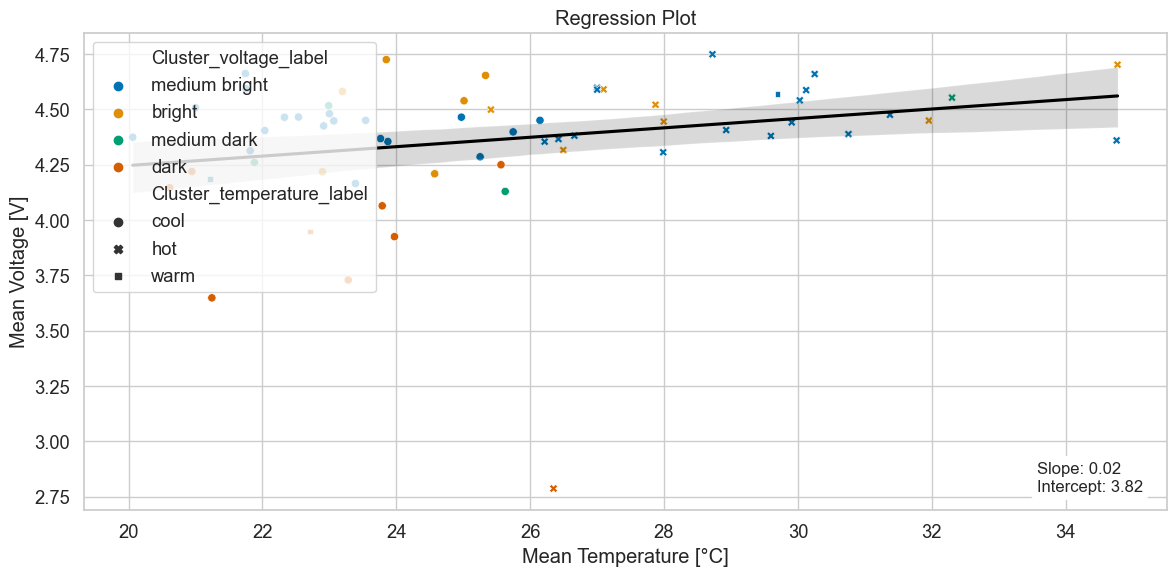

In [32]:
def plot_regression(data_frame, x_column, y_column, hue_column, style_column, title="Regression Plot"):
    """
    Plot a regression plot with scatter points and a regression line.

    Parameters:
        data_frame (pd.DataFrame): DataFrame containing the data.
        x_column (str): Column for the x-axis.
        y_column (str): Column for the y-axis.
        hue_column (str): Column for hue (color).
        style_column (str): Column for style (marker style).
        title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=data_frame, x=x_column, y=y_column, hue=hue_column, style=style_column, legend="brief",
        palette="colorblind"
    )
    model = LinearRegression()
    X = data_frame[[x_column]]
    Y = data_frame[y_column]
    model.fit(X, Y)
    slope = model.coef_[0]
    intercept = model.intercept_
    sns.regplot(data=data_frame, x=x_column, y=y_column, scatter=False, color="black", ci=95, ax=plt.gca())
    plt.legend(loc="upper left")
    plt.title(title)
    plt.ylabel('Mean Voltage [V]')
    plt.xlabel('Mean Temperature [°C]')
    equation_text = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}"
    plt.annotate(equation_text, xy=(0.88, 0.04), xycoords="axes fraction", size=12,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

    plt.tight_layout()
    plt.savefig(f"../plots/{title}.png")
    plt.show()


plot_regression(df_combined, "temperature_mean", "voltage_mean", "Cluster_voltage_label", "Cluster_temperature_label",
                title="Regression Plot")

#### 6.1.2: Monthly Regression Analysis and Cluster Statistics
*Focusing on monthly data, this code plots scatter plots with regression lines for each month, fitting linear regression models to discern patterns. It includes error handling for unsuccessful model fits, and annotation of plots with slope and R-squared values, offering an examination of monthly trends.*


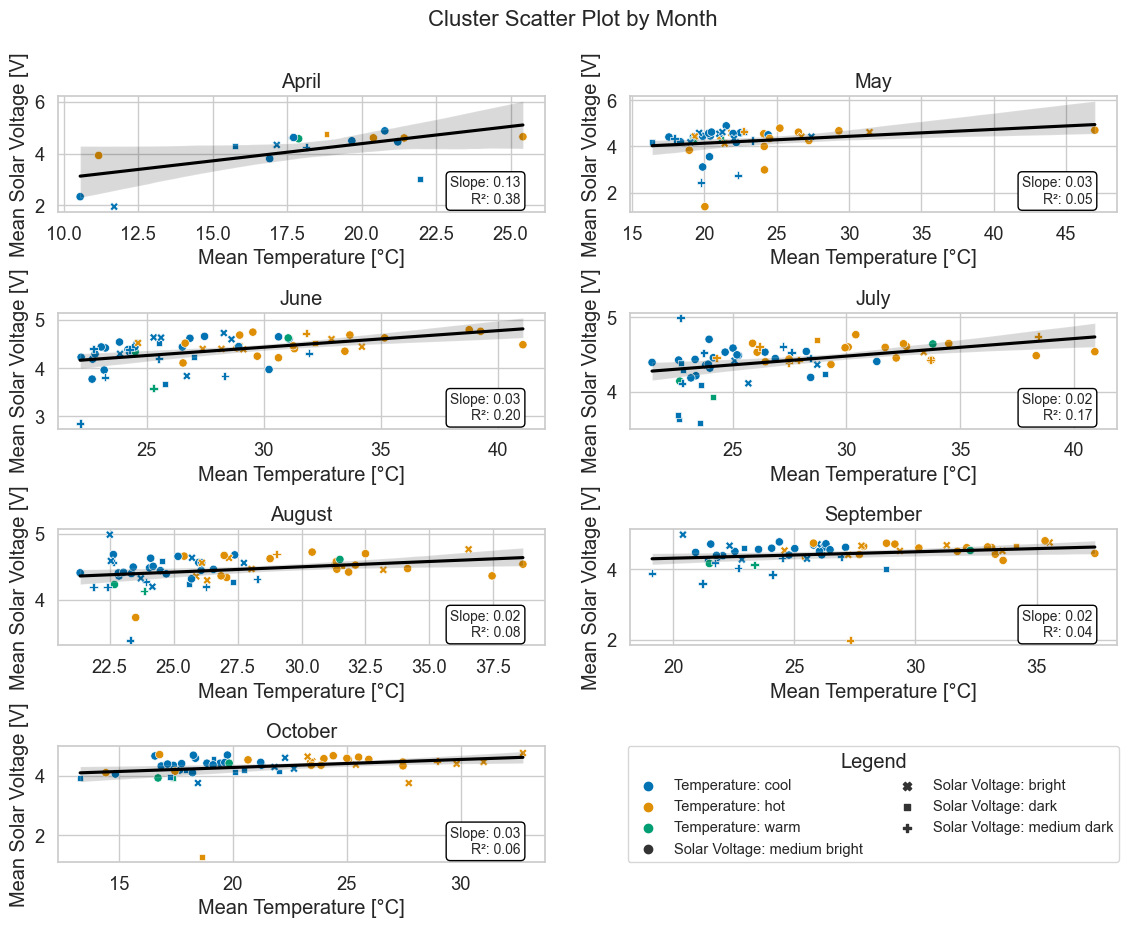

In [54]:
MONTH_NAMES = ["April", "May", "June", "July", "August", "September", "October"]
MONTH_RANGE = range(4, 11)


def plot_cluster_scatter(data_frame):
    """
    Plot cluster scatter plots by month.

    Parameters:
        data_frame (pd.DataFrame): DataFrame containing the data.
    """
    fig, axs = plt.subplots(4, 2, figsize=(12, 10))
    axs = axs.flatten()

    for i, month in enumerate(MONTH_RANGE):
        data_frame_month = data_frame[i]

        temp_col = f"temperature_{month}_mean"
        solar_col = f"voltage_{month}_mean"
        temp_cluster_col = f"Cluster_temperature_{month}_label"
        solar_cluster_col = f"Cluster_voltage_{month}_label"
        data_frame_month[temp_col] = pd.to_numeric(data_frame_month[temp_col], errors="coerce")
        data_frame_month[solar_col] = pd.to_numeric(data_frame_month[solar_col], errors="coerce")

        month_data = data_frame_month.dropna(subset=[temp_col, solar_col])
        fig.suptitle("Cluster Scatter Plot by Month\n\n\n", fontsize=16, y=0.93)

        if not month_data.empty:
            X = sm.add_constant(month_data[temp_col])
            y = month_data[solar_col]

            try:
                model = sm.OLS(y, X).fit()
                slope = model.params[1]
                r_squared = model.rsquared

                sns.scatterplot(data=month_data, x=temp_col, y=solar_col, hue=temp_cluster_col, style=solar_cluster_col,
                                ax=axs[i], legend=False)

                sns.regplot(data=month_data, x=temp_col, y=solar_col, ax=axs[i], scatter=False, color="black")

                axs[i].annotate(f"Slope: {slope:.2f}\nR²: {r_squared:.2f}", xy=(0.95, 0.05), xycoords="axes fraction",
                                ha="right", va="bottom", size=10,
                                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

            except Exception as e:
                print(f"Error in regression model for month {month}: {e}")
                axs[i].set_title(f"{MONTH_NAMES[i - 1]} (model not fit)")
            axs[i].set_title(f"{MONTH_NAMES[i - 1]}")
            axs[i].grid(True)

        else:
            axs[i].set_title(f"{MONTH_NAMES[i - 1]} (no data)")
            fig.delaxes(axs[i])  # Remove axis if no data

    last_ax = axs[-1]

    sns.scatterplot(data=month_data, x=temp_col, y=solar_col, hue=temp_cluster_col, ax=last_ax,
                    alpha=0)

    sns.scatterplot(data=month_data, x=temp_col, y=solar_col, style=solar_cluster_col, ax=last_ax,
                    alpha=0)

    handles, labels = last_ax.get_legend_handles_labels()
    temp_handles, temp_labels = handles[:len(temperature_labels)], labels[:len(temperature_labels)]
    radiation_handles, radiation_labels = handles[len(temperature_labels):], labels[len(temperature_labels):]

    last_ax.legend(temp_handles + radiation_handles,
                   ["Temperature: " + label for label in temp_labels] + ["Solar Voltage: " + label for label in
                                                                         radiation_labels], loc='center',
                   title="Legend", fontsize=10.5, ncol=2)

    last_ax.axis('off')

    for i, ax in enumerate(axs[:-1]):
        ax.set_ylabel("Mean Solar Voltage [V]")
        ax.set_xlabel("Mean Temperature [°C]")
        ax.set_title(MONTH_NAMES[i])

    plt.subplots_adjust(top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.savefig(f"../plots/cluster_scatter.png")
    plt.show()


plot_cluster_scatter(df_combined_all)

#### 6.1.3: Correlation Analysis Between Temperature and Solar Data
*This part of the analysis calculates and visualizes the correlation between temperature and solar data. The code uses pandas to compute the correlation matrix and seaborn to create a heatmap, illustrating the relationship between these two key data points.*


Correlation: 0.25517883221726173 P-value: 0.043548577849098276


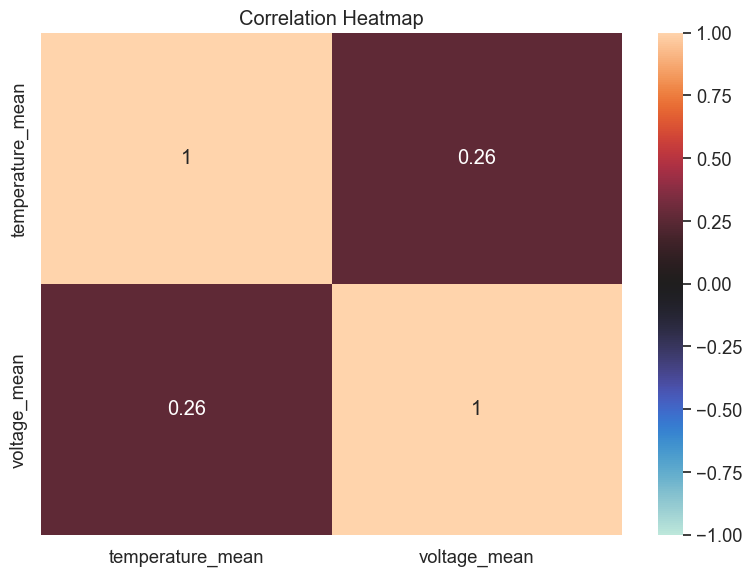

In [34]:
def plot_correlation_heatmap(data_frame, columns, title="Correlation Heatmap"):
    """
    Plot a correlation heatmap for selected columns.

    Parameters:
        data_frame (pd.DataFrame): DataFrame containing the data.
        columns (list): List of column names to include in the heatmap.
        title (str): Title of the plot.
    """
    correlation_matrix = data_frame[columns].corr().round(2)
    correlation, p_value = pearsonr(data_frame[columns[0]], data_frame[columns[1]])
    print('Correlation:', correlation, 'P-value:', p_value)
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="icefire", vmin=-1, vmax=1)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"../plots/correlation_heatmap.png")
    plt.show()


plot_correlation_heatmap(df_combined, ["temperature_mean", "voltage_mean"], title="Correlation Heatmap")

### 6.2: Mapping Cluster Labels to Numerical Values
*This section describes the process of converting cluster labels into numerical values for easier analysis. It involves mapping labels to integers and adjusting DataFrame indices, thus preparing the data for further numerical analysis and visualization.*


In [35]:
def map_clusters(df_temp, df_dni):
    """
    Map cluster labels to numerical values for temperature and DNI DataFrames.

    Parameters:
        df_temp (DataFrame): DataFrame containing temperature data with 'Cluster' column.
        df_dni (DataFrame): DataFrame containing DNI data with 'Cluster' column.

    Returns:
        df_temp (DataFrame): Updated temperature DataFrame with numerical cluster values.
        df_dni (DataFrame): Updated DNI DataFrame with numerical cluster values.
    """

    cluster_mapping_temp = {"cool": 0, "warm": 1, "hot": 2}
    df_temp["Cluster"] = df_temp["new_label"].map(cluster_mapping_temp)

    cluster_mapping_dni = {"dark": 0, "medium dark": 1, "medium bright": 2, "bright": 3}
    df_dni["Cluster"] = df_dni["new_label"].map(cluster_mapping_dni)

    df_dni.set_index("Sensor", inplace=True)
    df_temp.set_index("Sensor", inplace=True)

    return df_temp, df_dni


df_temperature_all_updated, df_radiation_all_updated = map_clusters(df_temperature_all_updated,
                                                                    df_radiation_all_updated)

### 6.3: Heatmap Visualization of Cluster Statistics
*This code creates heatmaps to visualize cluster statistics for temperature and DNI data. It involves grouping data by cluster value, calculating mean group values, and using seaborn to plot the resultant heatmaps, offering a clear and concise visualization of cluster distributions.*


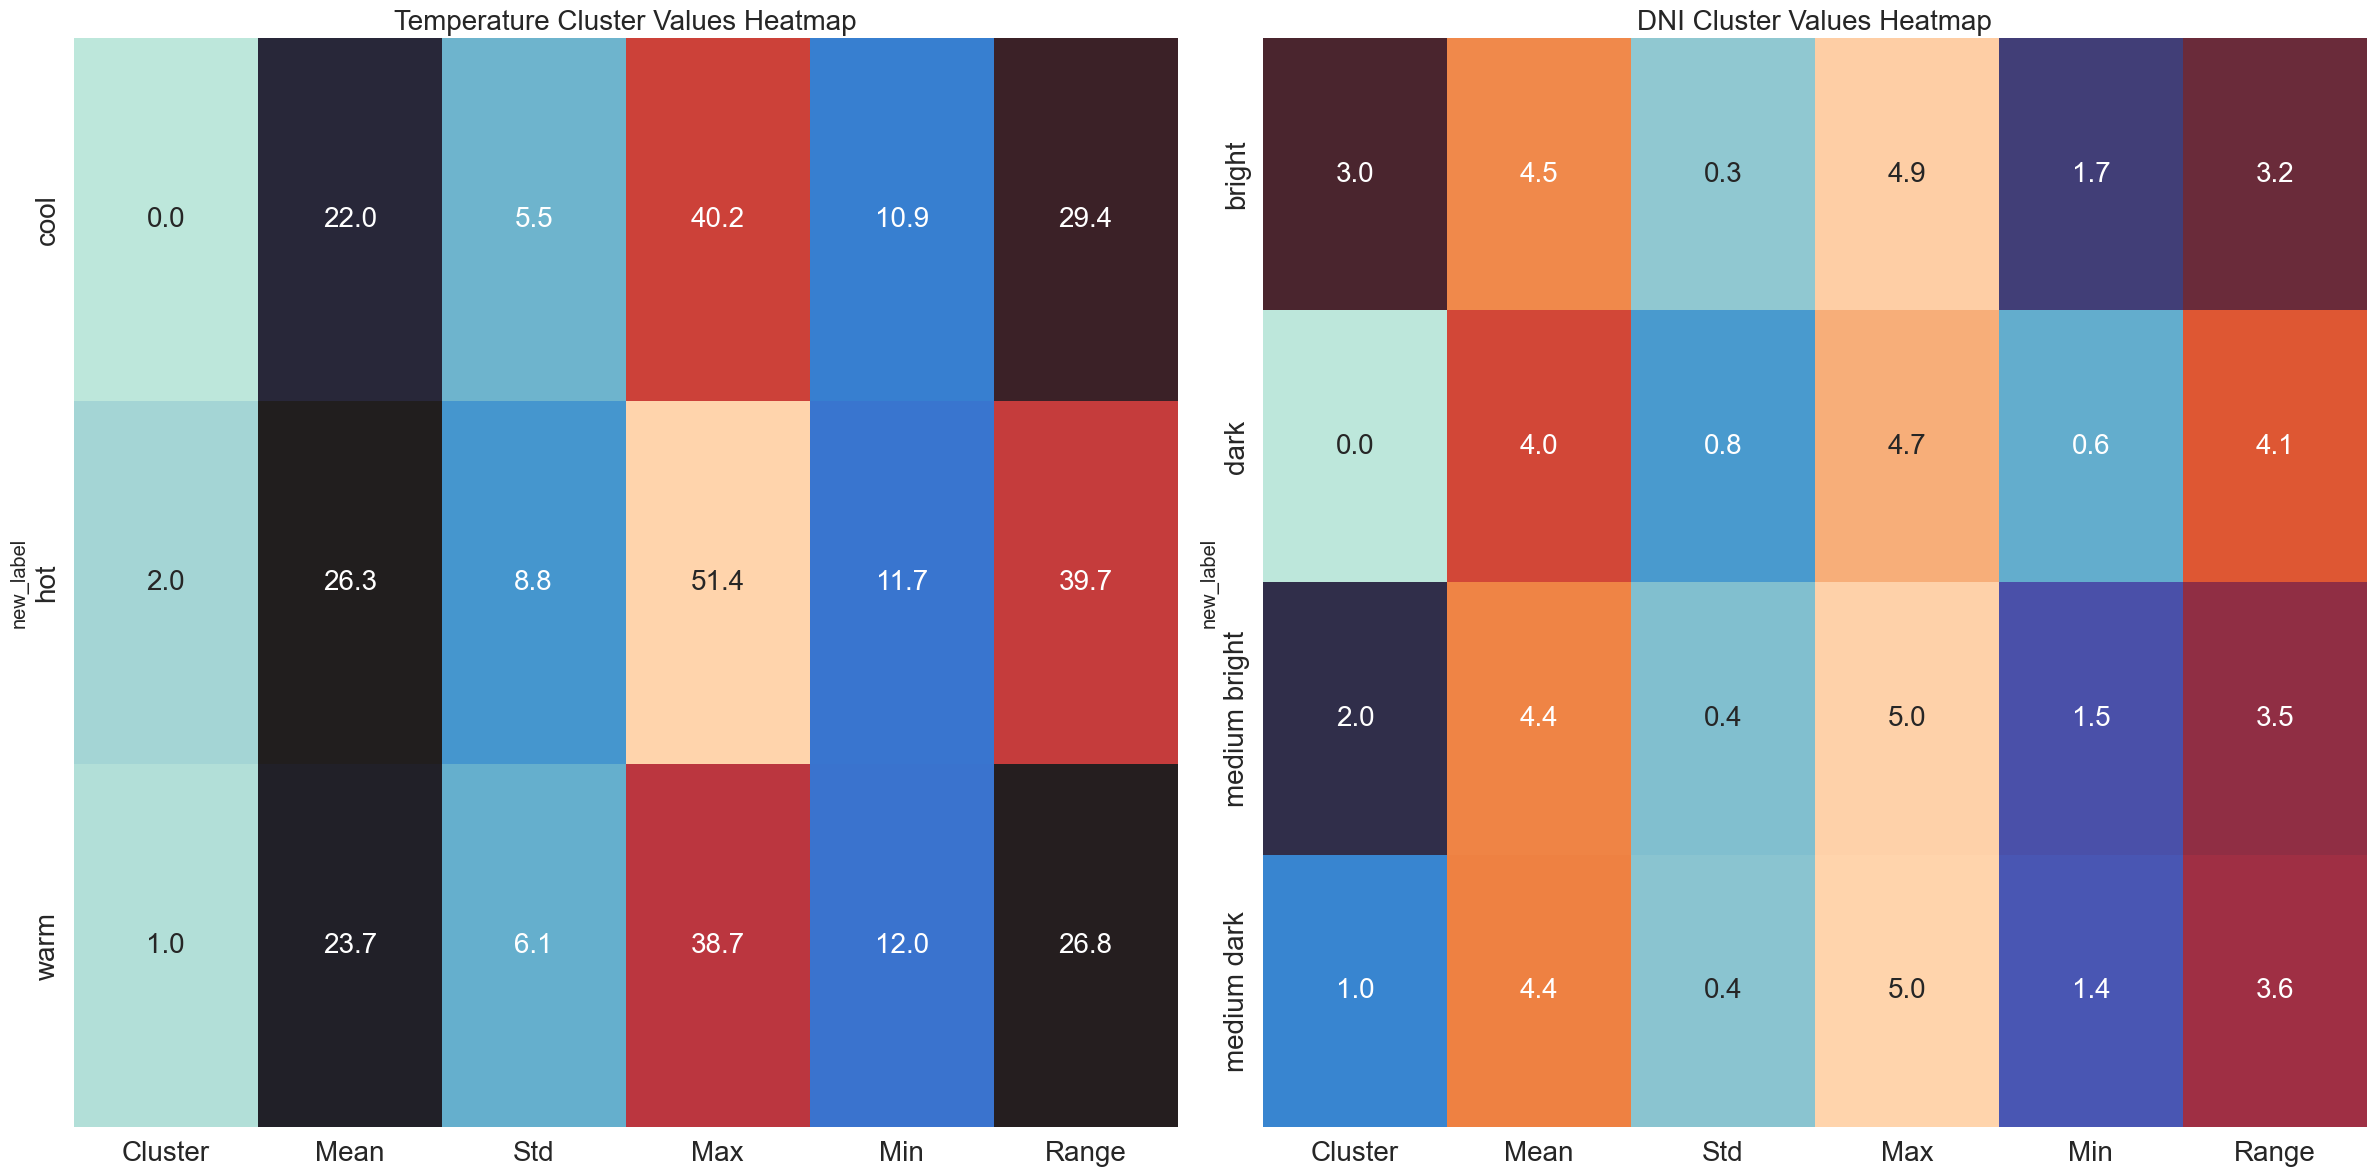

In [36]:
def plot_cluster_heatmap(data_frame, plot_title, axis, decimal_places=1):
    """
    Plot a heatmap of cluster values for a given DataFrame.

    Parameters:
        data_frame (DataFrame): The DataFrame containing cluster values.
        plot_title (str): The title for the heatmap.
        axis (matplotlib.axes._subplots.AxesSubplot): The axis to plot the heatmap.
        decimal_places (int, optional): The number of decimal places for annotations (default is 1).
    """
    sns.heatmap(data_frame.groupby("new_label").mean(), annot=True, cmap="icefire", fmt=f".{decimal_places}f",
                cbar=False,
                ax=axis, annot_kws={"size": 20})
    axis.set_title(plot_title, fontsize=20)
    axis.set_xticklabels(axis.get_xticklabels(), fontsize=20)
    axis.set_yticklabels(axis.get_yticklabels(), fontsize=20)


def plot_cluster_heatmaps():
    """
    Plot heatmaps for temperature and DNI cluster values.
    """
    fig, (axis0, axis1) = plt.subplots(1, 2, figsize=(24, 12))
    plot_cluster_heatmap(df_temperature_all_updated, "Temperature Cluster Values Heatmap", decimal_places=1, axis=axis0)
    plot_cluster_heatmap(df_radiation_all_updated, "DNI Cluster Values Heatmap", decimal_places=1, axis=axis1)
    plt.tight_layout()
    plt.savefig("../plots/heatmap.png")
    plt.show()


plot_cluster_heatmaps()

---
## Part 7: Analyzing Survey Data
---
*This segment focuses on merging cluster data with survey data, conducting correlation analysis, and exploring cluster-related correlations in both datasets. It encompasses preprocessing, correlation plotting, and data merging to facilitate a comprehensive analysis of survey responses.*


*Define columns of interest in the survey data.*

In [37]:
# Basic Information
basic_info = [
    "orientation_balcony_short",
    "latitude",
    "longitude",
    "floor",
]

# Tank and Sunlight
tank_sunlight = [
    "tank_position",
    "tank_location",
    "sunshine_window_user",
]

# Orientation and Climate
orientation_climate = [
    "compass_degree",
    "Cluster",
    "rating_climate_user",
]

# Building Features
building_features = [
    "blinds_frequency",
    "railing_transparancy",
]

# Location and Population
location_population = [
    "population",
    "type",
]

# Combine all categories into one list
columns_of_interest = (
        basic_info
        + tank_sunlight
        + orientation_climate
        + building_features
        + location_population
)

### 7.1: Merging Cluster and Survey Data
*This procedure merges cluster data with survey responses. It is designed to preprocess data for temperature and solar voltage, align survey responses with cluster data, and rename columns for clarity, ultimately enabling a thorough analysis of merged data.*


In [38]:
def preprocess_cluster_data(cluster_data, mode):
    """
    Preprocesses cluster data by merging it with survey data and filtering based on survey responses.

    Parameters:
        cluster_data (pd.Series): Cluster data for temperature or solar voltage.
        mode (str): Either "Temperature" for temperature or "Radiation" for solar voltage.

    Returns:
        pd.DataFrame: Preprocessed and filtered data.
    """
    # Get survey data and define a residency type
    survey_data = survey_data_instance.get_survey_data()
    survey_data = define_residency_type(survey_data)
    survey_data.set_index('deviceId_boum', inplace=True)
    survey_data = survey_data.T

    # Rename columns for clarity
    names = [
        f"temperature_boum_{col[:8]}_boum_{col[:8]}" if mode == "Temperature" else f"solarVoltage_boum_{col[:8]}_boum_{col[:8]}"
        for col in survey_data.columns]

    survey_data.columns = names
    survey_data = survey_data.T.reset_index(names='Sensor')
    merged_df = pd.merge_ordered(survey_data, cluster_data, on='Sensor')
    merged_df = merged_df[(merged_df['answered_message'] == True) | (merged_df['did_survey'] == True)]

    return merged_df


def define_residency_type(survey_data):
    """
    Defines the residency type based on population.

    Parameters:
        survey_data (pd.DataFrame): Survey data.

    Returns:
        pd.DataFrame: Survey data with "type" column indicating a residency type.
    """
    survey_data["type"] = "urban"
    survey_data.loc[survey_data["population"] < 15000, "type"] = "rural"
    return survey_data


# Preprocess cluster data for temperature and solar voltage
merged_df_temp = preprocess_cluster_data(df_temperature_all_updated["Cluster"], mode="Temperature")
merged_df_dni = preprocess_cluster_data(df_radiation_all_updated["Cluster"], mode="Radiation")

### 7.2: Correlation Analysis in Cluster and Survey Data
*Here, the focus is on statistically relevant correlations within the data. The code performs correlation analysis using pandas and seaborn, filtering for significant correlations and visualizing these relationships in a heatmap, thereby highlighting key insights and patterns in the data.*


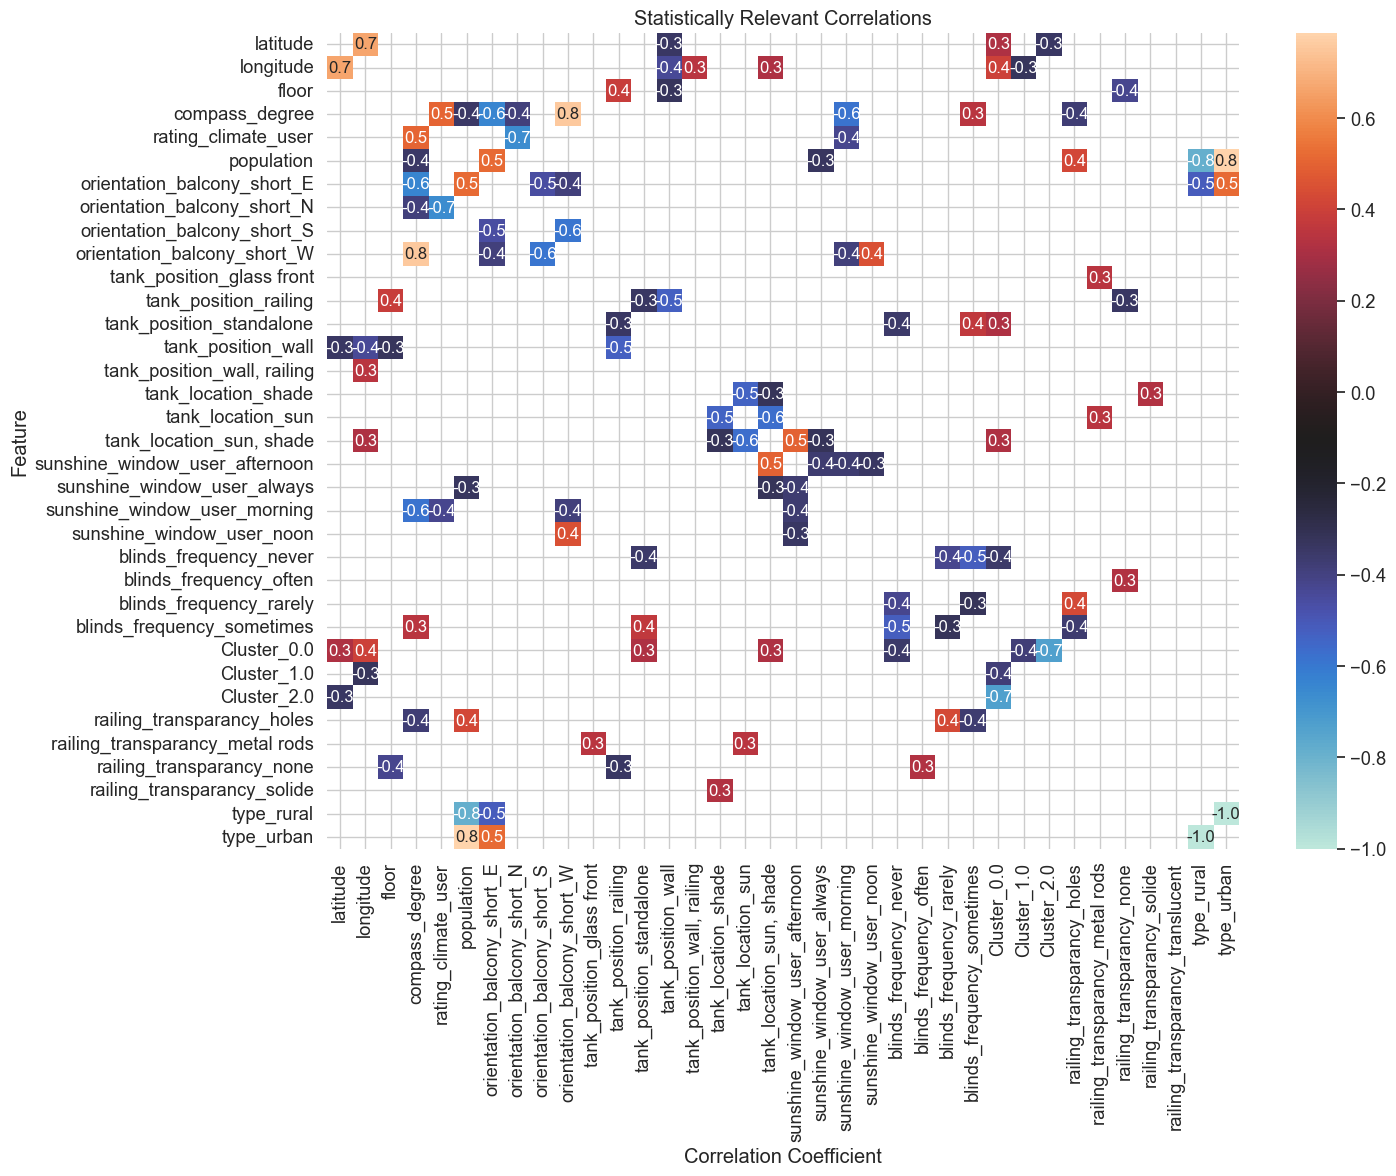

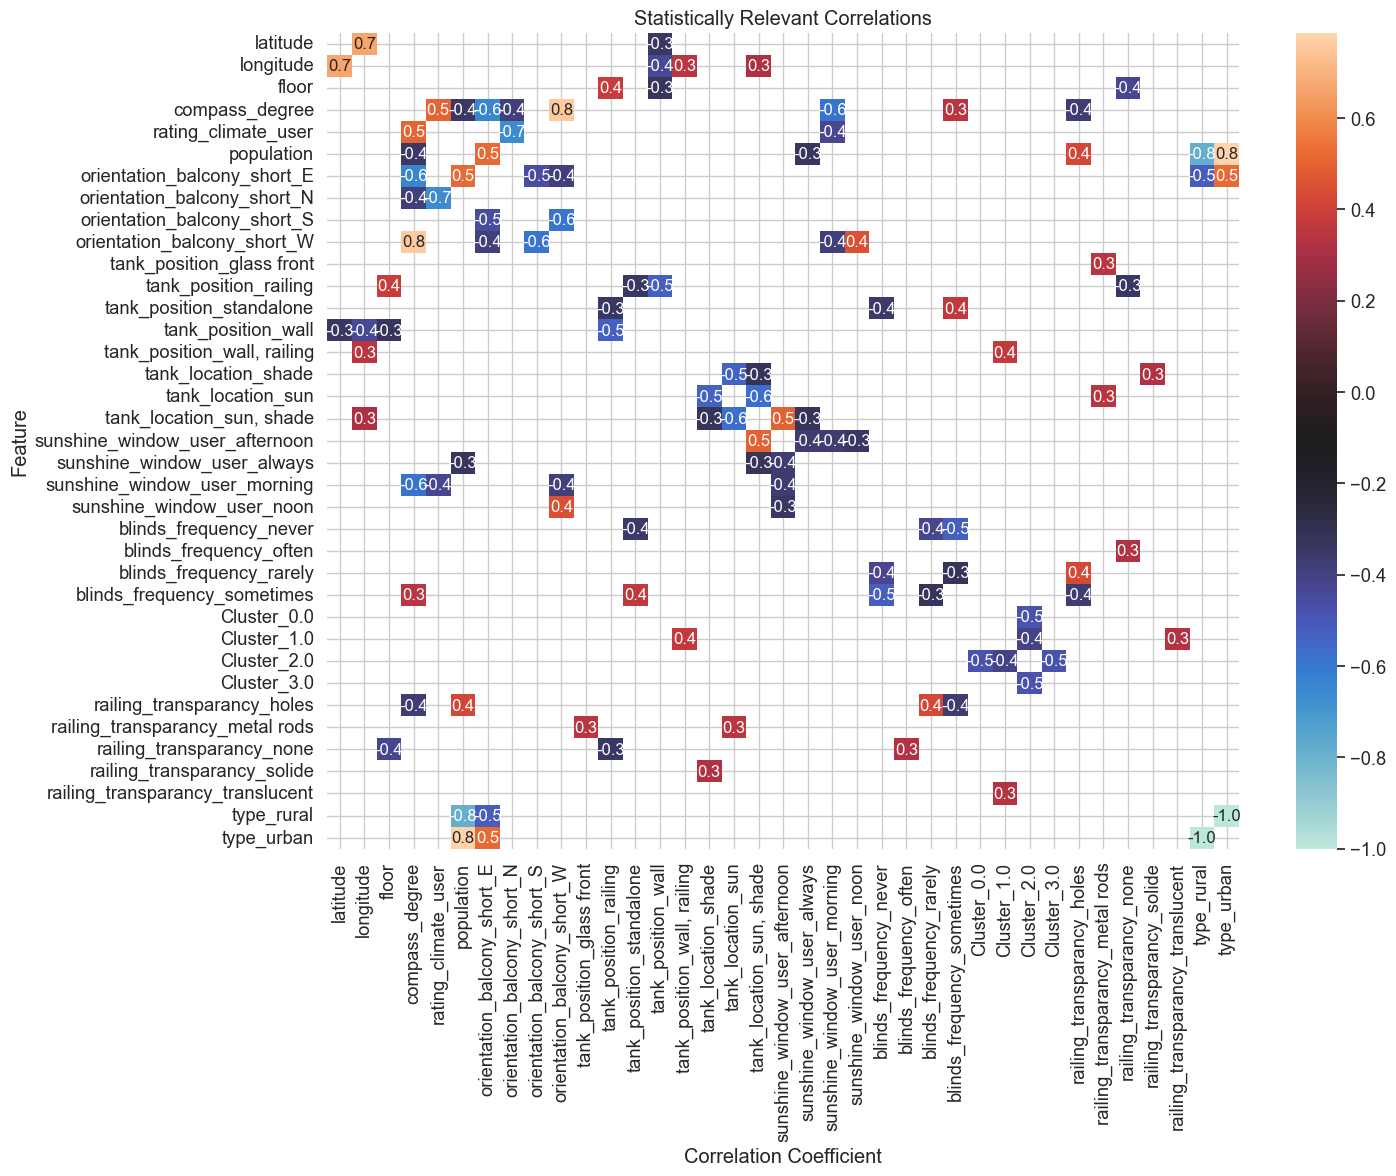

In [39]:
def plot_statistically_relevant_correlations(dataframe, columns, p_value_threshold, correlation_threshold, mode):
    """
    Plot statistically relevant correlations between features in a dataframe.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        columns (list): List of columns to consider for correlation analysis.
        p_value_threshold (float): Threshold for p-value to determine statistical significance.
        correlation_threshold (float): Threshold for correlation coefficient to consider relevant.
        mode (str): Either 'Temperature' or 'Radiation' indicating the mode.

    Returns:
        pd.DataFrame: Filtered correlation matrix.
    """
    data = dataframe[columns]
    data = pd.get_dummies(data, columns=["orientation_balcony_short", "tank_position", "tank_location",
                                         "sunshine_window_user", "blinds_frequency", "Cluster",
                                         "railing_transparancy", "type"])

    correlation_matrix = data.corr(method='pearson')
    p_value_matrix = data.corr(method=lambda x, y: pearsonr(x, y)[1])
    filtered_correlation_matrix = correlation_matrix[(abs(p_value_matrix) < p_value_threshold) & (
            abs(correlation_matrix) > correlation_threshold
    )].dropna(thresh=1)

    plt.figure(figsize=(15, 12))
    sns.heatmap(filtered_correlation_matrix, annot=True, cmap="icefire", fmt=".1f", annot_kws={"size": 12})
    plt.title("Statistically Relevant Correlations")
    plt.xlabel("Correlation Coefficient")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(f"../plots/statistically_relevant_correlations_{mode}.png")
    plt.show()
    return filtered_correlation_matrix, p_value_matrix


filtered_correlation_matrix_temp, p_value_matrix_temp = plot_statistically_relevant_correlations(
    merged_df_temp, columns_of_interest, p_value_threshold=0.05, correlation_threshold=0, mode='Temperature'
)
filtered_correlation_matrix_dni, p_value_matrix_dni = plot_statistically_relevant_correlations(
    merged_df_dni, columns_of_interest, p_value_threshold=0.05, correlation_threshold=0, mode='Radiation'
)

### 7.3: Cluster-Related Correlation Analysis
*This code isolates cluster-related correlations for a detailed examination. It processes the correlation matrix to separate cluster-related columns and then concatenates these columns into a new DataFrame, providing a focused view of cluster-specific relationships within the data.*


In [40]:
def process_correlation_results(correlation_matrix, cluster_prefix='Cluster'):
    """
    Process the correlation matrix by filtering out cluster-related columns.
    
    Parameters:
        correlation_matrix (pd.DataFrame): The correlation matrix to process.
        cluster_prefix (str, optional): The prefix used for cluster-related columns. Default is 'Cluster'.
    
    Returns:
        pd.DataFrame: The processed correlation matrix with cluster-related columns separated.
    """
    cluster_index = [i for i in correlation_matrix.index if cluster_prefix in i]
    correlation_matrix = correlation_matrix.drop(index=cluster_index)
    cluster_columns = [col for col in correlation_matrix.columns if col.startswith(cluster_prefix)]
    correlation_result = pd.DataFrame()
    for col in cluster_columns:
        correlation_result = pd.concat([correlation_result, correlation_matrix[col].dropna()], axis=1)
    return correlation_result


corr_results_temperature = process_correlation_results(filtered_correlation_matrix_temp)
corr_results_radiation = process_correlation_results(filtered_correlation_matrix_dni)

*set labels*

In [41]:
temperature_labels = ["cool", "warm", "hot"]
radiation_labels = ["dark", "medium dark", "medium bright", "bright"]

### 7.4: Visualizing Correlations in Cluster and Survey Data
*This section plots statistically significant correlations between various features in the dataset. The approach involves filtering correlations based on p-values and correlation coefficients, creating dummy variables for categorical data, and visualizing the results in a heatmap, providing a clear understanding of feature relationships.*


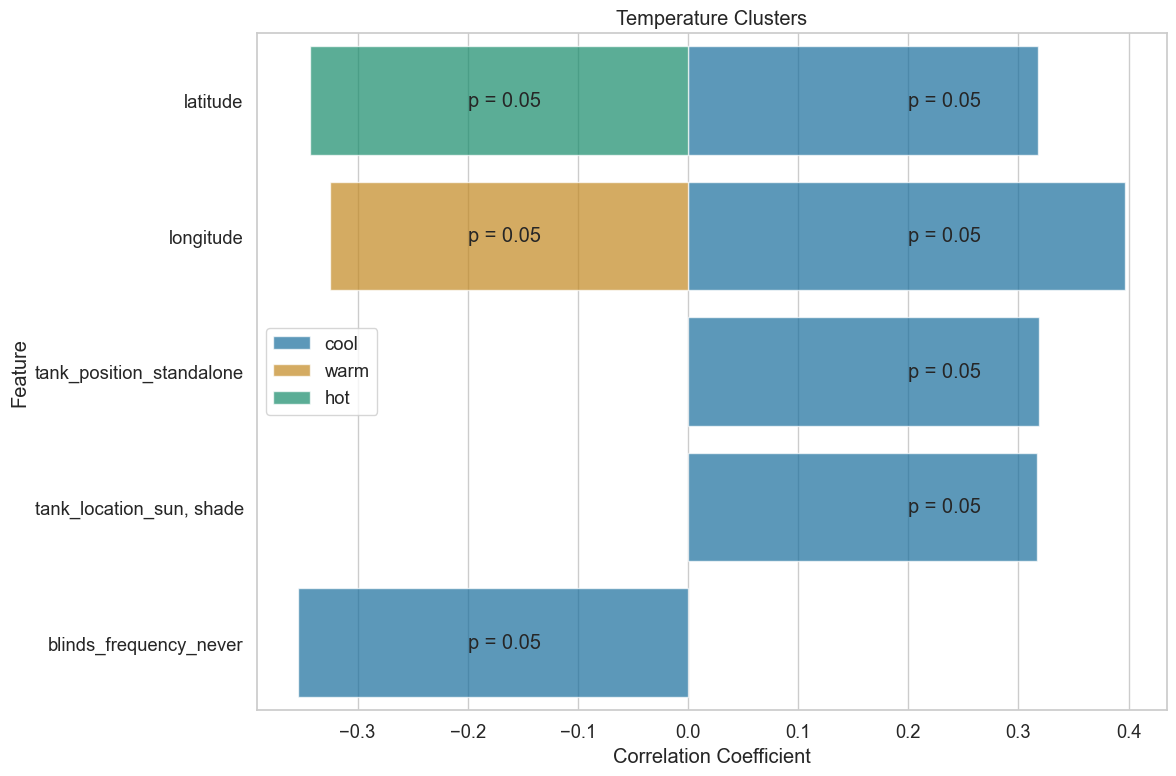

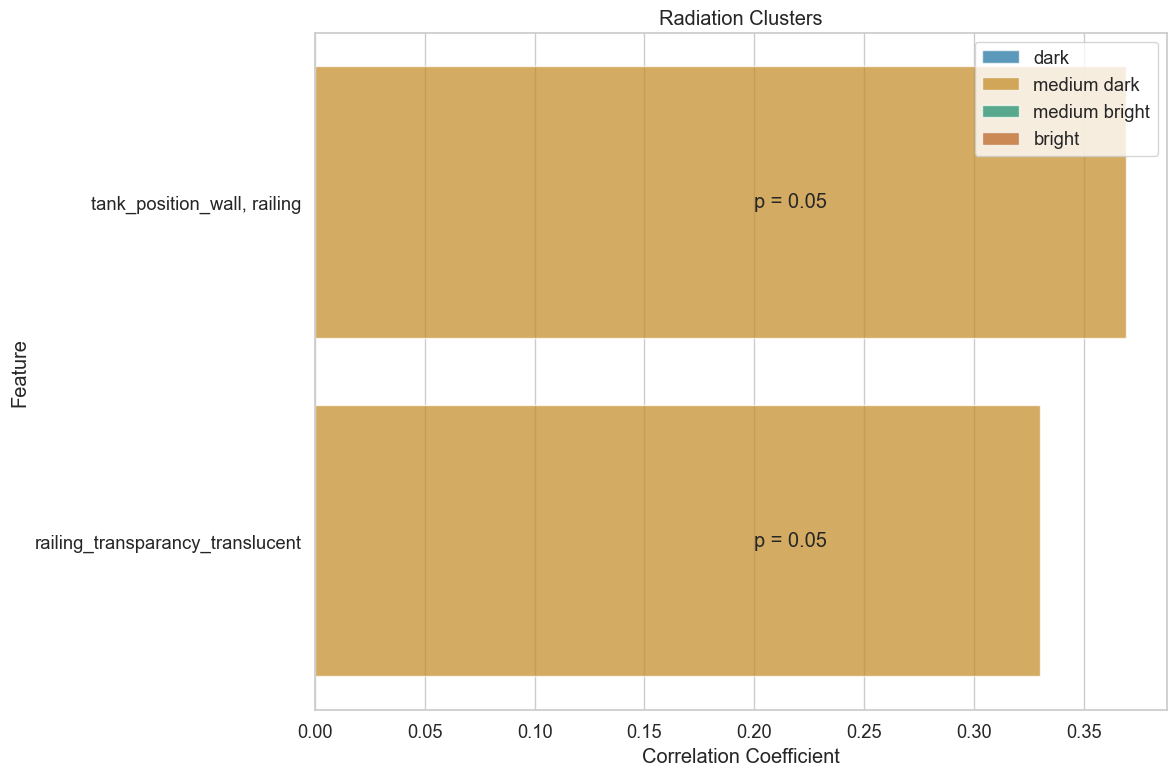

In [42]:
temperature_labels = ["cool", "warm", "hot"]
radiation_labels = ["dark", "medium dark", "medium bright", "bright"]


def plot_cluster_correlations(corr_results, p_value_matrix, title, cluster_labels, colors, alpha=0.7,
                              mode='Temperature'):
    """
    Plot cluster correlations for different clusters.

    Parameters:
        corr_results (pd.DataFrame): The DataFrame containing cluster correlations.
        p_value_matrix (pd.DataFrame): The DataFrame containing cluster p-values.
        title (str): The title for the plot.
        cluster_labels (list): A list of cluster labels.
        colors (list): A list of colors for the clusters.
        alpha (float, optional): The transparency of the bars. Default is 0.7.
        mode (str, optional): The mode of the correlations (e.g., 'Temperature' or 'Radiation'). Default is 'Temperature'.
    """
    # Edit p-values
    for col in p_value_matrix.columns:
        for row in p_value_matrix.index:
            p_value = p_value_matrix.at[row, col]
            if pd.notnull(p_value) and np.isfinite(p_value):
                if p_value <= 0.01:
                    p_value_matrix.at[row, col] = 0.01
                elif 0.01 < p_value <= 0.05:
                    p_value_matrix.at[row, col] = 0.05
                elif 0.05 < p_value <= 0.1:
                    p_value_matrix.at[row, col] = 0.1
                else:
                    p_value_matrix.at[row, col] = None
                    
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, (label, color) in enumerate(zip(cluster_labels, colors), start=1):
        cluster_col = f"Cluster_{i - 1}.0"

        if cluster_col in corr_results:
            barplot = sns.barplot(
                data=corr_results,
                y=corr_results.index,
                x=cluster_col,
                color=color,
                label=label,
                alpha=alpha,
            )
        for bar, feature in zip(barplot.patches, corr_results.index):
            p_value = p_value_matrix.at[feature, cluster_col]
            value = corr_results.at[feature, cluster_col]
            if pd.notnull(p_value) and np.isfinite(p_value):
                text_x = -0.2 if value < 0 else 0.2
                ax.text(text_x, bar.get_y() + bar.get_height() / 2, f"p = {p_value:.2f}",
                        va='center')

    ax.set_title(title)
    ax.set_xlabel("Correlation Coefficient")
    ax.set_ylabel("Feature")
    ax.legend(loc='best')
    plt.tight_layout()
    plt.savefig(f"../plots/cluster_correlations_{mode}.png")
    plt.show()


# Define the color palettes
radiation_colors = sns.color_palette('colorblind')
temperature_colors = sns.color_palette('colorblind')

# Call the function to plot temperature and radiation cluster correlations
plot_cluster_correlations(
    corr_results_temperature,
    p_value_matrix_temp,
    "Temperature Clusters",
    temperature_labels,
    temperature_colors,
    0.7,
    'Temperature'
)
plot_cluster_correlations(
    corr_results_radiation,
    p_value_matrix_dni,
    "Radiation Clusters",
    radiation_labels,
    radiation_colors,
    0.7,
    'Radiation'
)

## Part 8: Analyzing Cluster Data
*Here, the code analyzes the cluster-related correlations and visualizes the results in a heatmap to aid in understanding of feature relationships within the data.*

### 8.1: Calculating Mean Cluster Values
*Here, the mean values for each cluster is analyzed, combining the cluster data with the original sensor data. The process involves selecting relevant sensor data for each cluster, computing mean values, and creating a new DataFrame to house these calculations, offering insights into the average characteristics of each cluster.*


In [43]:
def calculate_cluster_mean(data, org_data):
    """
    Calculate the mean of each cluster for the given data.

    Parameters:
        data (pd.DataFrame): The data containing cluster information.
        org_data (pd.DataFrame): The original data with sensor information.

    Returns:
        pd.DataFrame: A DataFrame containing the mean values for each cluster.
    """
    cluster_means = {}
    unique_clusters = org_data['new_label'].unique()
    for cluster in unique_clusters:
        cluster_sensors = org_data[org_data['new_label'] == cluster]['Sensor'].explode()
        cluster_means[f"Cluster {cluster}"] = data[cluster_sensors].mean(axis=1)
    return pd.DataFrame(cluster_means)


mean_all_cluster_temperature = calculate_cluster_mean(boum_data, df_temperature_all_org)
mean_all_cluster_radiation = calculate_cluster_mean(boum_data, df_radiation_all_org)

### 8.2: Merging Cluster and Original Data
*This section merges cluster data with original sensor data. The process includes selecting sensor data corresponding to each cluster, calculating mean values, and compiling these calculations in a new DataFrame. This step is important for understanding the average characteristics of each cluster in the context of the original dataset.*


In [44]:
def merge_all_cluster_data(df_dni_all_updated, df_temp_all_updated):
    """
    Merge and organize cluster data from temperature and DNI datasets.

    Parameters:
        df_dni_all_updated (pd.DataFrame): The DNI dataset with cluster information.
        df_temp_all_updated (pd.DataFrame): The temperature dataset with cluster information.

    Returns:
        pd.DataFrame: A merged DataFrame containing cluster data.
    """
    df_dni_all_updated.reset_index(inplace=True)
    df_temp_all_updated.reset_index(inplace=True)
    df_temp_all_updated["Sensor"] = df_temp_all_updated["Sensor"].str[-8:]
    df_dni_all_updated["Sensor"] = df_dni_all_updated["Sensor"].str[-8:]
    df_all = pd.merge_ordered(
        df_temp_all_updated[["Sensor", "new_label", "Cluster"]],
        df_dni_all_updated[["Sensor", "new_label", "Cluster"]],
        on="Sensor",
    )
    df_all.set_index("Sensor", inplace=True)
    return df_all


df_all = merge_all_cluster_data(df_radiation_all_updated, df_temperature_all_updated)

### 8.3: Correlation Analysis Between Temperature and Radiation Clusters
*This section focuses on analyzing the correlation between temperature and radiation clusters. It includes two primary functions: `plot_cluster_correlation_heatmap` and `calculate_pearson_correlation`. The first function plots a heatmap to visualize the Pearson correlation between the clusters, enhancing understanding of their interrelationship. The second function calculates the actual Pearson correlation coefficient and its corresponding p-value, providing statistical evidence of the correlation’s significance. Together, these functions offer a comprehensive view of how closely related the temperature and radiation clusters are in the dataset.*


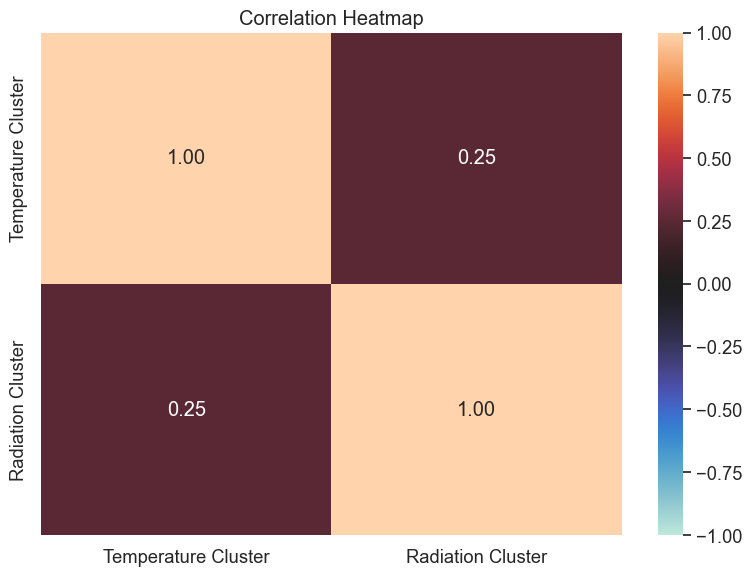

Correlation: 0.24692591139252879 P-value: 0.051057843428493975


In [45]:
def plot_cluster_correlation_heatmap(cluster_data):
    """
    Plot a heatmap of Pearson correlation between Temperature and Radiation clusters.

    Parameters:
        cluster_data (pd.DataFrame): DataFrame containing temperature and radiation cluster data.
    """
    cluster_data.rename(columns={'Cluster_x': 'Temperature Cluster', 'Cluster_y': 'Radiation Cluster'}, inplace=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cluster_data[['Temperature Cluster', 'Radiation Cluster']].corr(),
        annot=True, cmap="icefire", vmin=-1, vmax=1, fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.savefig("../plots/correlation_heatmap_Clusters.png")
    plt.show()


def calculate_pearson_correlation(cluster_data):
    """
    Calculate the Pearson correlation coefficient between Temperature and Radiation clusters.

    Parameters:
        cluster_data (pd.DataFrame): DataFrame containing temperature and radiation cluster data.
    """
    correlation, p_value = pearsonr(cluster_data["Temperature Cluster"], cluster_data["Radiation Cluster"])
    print('Correlation:', correlation, 'P-value:', p_value)


plot_cluster_correlation_heatmap(df_all)
calculate_pearson_correlation(df_all)

### 8.4: Visualizing Mean Cluster Values
*The focus here is on visualizing the mean values for each cluster. The code sorts clusters by mean values and utilizes seaborn to create descriptive boxplots. This visual representation helps in understanding the distribution and central tendencies within each cluster.*


Cluster cool    22.855848
Cluster warm    23.478209
Cluster hot     28.145554
dtype: float64


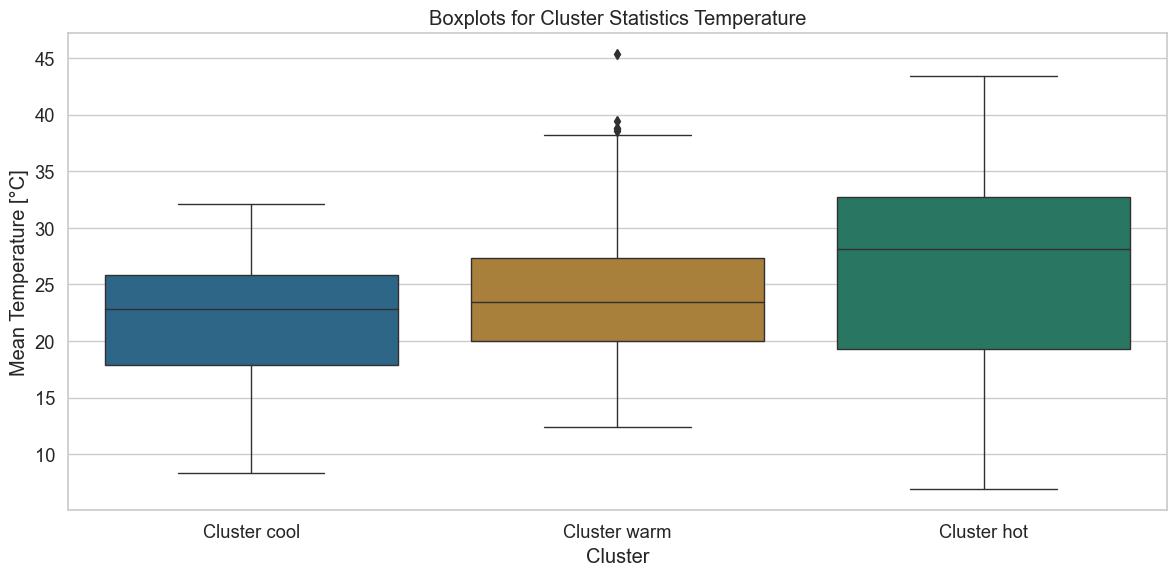

Cluster dark             4.102162
Cluster medium dark      4.469757
Cluster medium bright    4.498889
Cluster bright           4.508261
dtype: float64


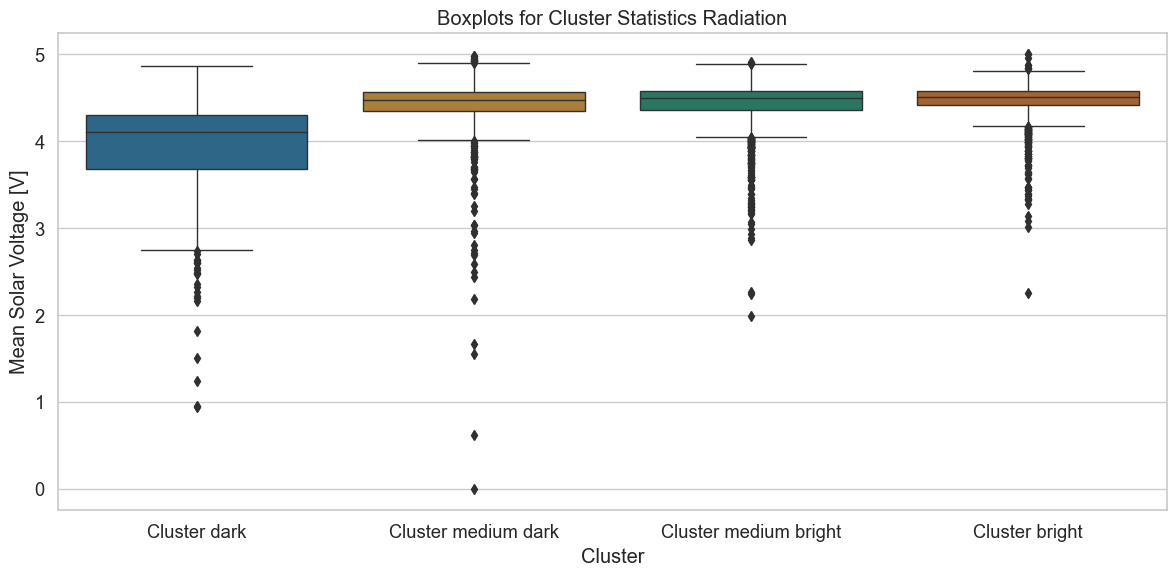

In [46]:
def plot_mean_cluster_values(cluster_data, plot_title, y_label, mode):
    """
    Plot boxplots for cluster statistics.

    Parameters:
        cluster_data (pd.DataFrame): DataFrame containing cluster statistics data.
        plot_title (str): Title for the plot.
        y_label (str): Label for the y-axis.
        mode (str): Mode indicating the type of data (e.g., 'temperature' or 'radiation').
    """
    sorted_clusters = cluster_data.median().sort_values().index
    print(cluster_data.median().sort_values())

    cluster_data_sorted = cluster_data[sorted_clusters]
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=cluster_data_sorted, palette="colorblind", linewidth=1, saturation=0.5, showfliers=True)
    plt.title(plot_title)
    plt.xlabel("Cluster")
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.savefig(f"../plots/boxplot_{mode}.png")
    plt.show()


plot_mean_cluster_values(mean_all_cluster_temperature, plot_title="Boxplots for Cluster Statistics Temperature",
                         y_label="Mean Temperature [°C]", mode='temperature')
plot_mean_cluster_values(mean_all_cluster_radiation, plot_title="Boxplots for Cluster Statistics Radiation",
                         y_label="Mean Solar Voltage [V]", mode='radiation')


*Merge cluster data from temperature and DNI datasets*

In [47]:
df_updated_all = pd.merge_ordered(df_radiation_all_updated, df_temperature_all_updated,
                                  on='Sensor')

---
## Part 9: Creating a Map with Folium
---
*This script uses Folium to create an interactive map displaying cluster data. It involves placing markers for each sensor based on latitude and longitude, with marker colors representing temperature and radiation clusters. The script also integrates a custom legend, enhancing the map’s interpretability and providing a geographical context to the cluster analysis.*


In [48]:
# Create a map centered around the mean latitude and longitude
map_center = [survey_data["latitude"].mean(), survey_data["longitude"].mean()]
mymap = folium.Map(location=map_center, zoom_start=8, max_zoom=15, min_zoom=8)

df_updated_all = df_updated_all.dropna()
temperature_colors = {"cool": 'blue', "warm": 'orange', "hot": 'red'}
radiation_colors = {"dark": 'lightblue', "medium dark": 'blue', "medium bright": 'orange', "bright": 'red'}

# Add markers to the map based on cluster information
for idx, row in df_updated_all.iterrows():
    sensor_id = row["Sensor"]
    temp_cluster = row["new_label_y"]
    rad_cluster = row["new_label_x"]
    temp_color = temperature_colors[temp_cluster]
    rad_color = radiation_colors[rad_cluster]

    # Get the latitude and longitude from the survey data
    sensor_data = survey_data[survey_data["deviceId_boum"].str.contains(sensor_id)]
    if not sensor_data.empty:
        lat, lon = sensor_data[["latitude", "longitude"]].values[0]
        folium.Marker(location=(lat, lon), radius=8, icon=folium.Icon(color=temp_color, icon="filled"), fill=True,
                      fill_opacity=0.7, tooltip=f"Temperature: {temp_cluster.capitalize()}", ).add_to(mymap)
        folium.CircleMarker(location=(lat, lon), radius=8, color=rad_color, fill=True, fill_opacity=0.7,
                            tooltip=f"Radiation: {rad_cluster.capitalize()}", ).add_to(mymap)

# Define the template for the legend
template = """
{% macro html(this, kwargs) %}
<div style="position: fixed; 
     bottom: 2px; left: 6px; width: 180px; height: %s; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background:white; padding:5px;">
     <b>Temperature</b><br>
     &nbsp; Cool &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
     &nbsp; Warm &nbsp; <i class="fa fa-map-marker fa-2x" style="color:orange"></i><br>
     &nbsp; Hot &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i><br
     <hr>
    <b>Radiation</b> <br>
     &nbsp; Low &nbsp; <i class="fa fa-circle fa-2x" style="color:lightblue"></i><br>
     &nbsp; Medium Low &nbsp; <i class="fa fa-circle fa-2x" style="color:blue"></i><br>
     &nbsp; Medium High &nbsp; <i class="fa fa-circle fa-2x" style="color:orange"></i><br>
     &nbsp; High &nbsp; <i class="fa fa-circle fa-2x" style="color:red"></i><br>
</div>
{% endmacro %}
"""
macro = MacroElement()
macro._template = Template(template)
mymap.get_root().add_child(macro)
mymap.save("../plots/map.html")

In [49]:
mymaps

NameError: name 'mymaps' is not defined